In [80]:
# def u_series(z, t, cv, H, n_terms=200):
#     """
#     Semi-analytical solution (Taylor 1942) for u(z,t) with
#     drained top, impermeable bottom, uniform cv.
#     z : array of depths [m]      (0 = top, H = bottom)
#     t : scalar time [yr]
#     cv: consolidation coefficient [m²/yr]
#     H : drainage length [m]      (bottom is impermeable)
#     """
#     z = np.atleast_1d(z)
#     series = np.zeros_like(z, dtype=float)
#     fac = np.pi / (2*H)
#     for n in range(n_terms):
#         m   = 2*n + 1
#         lam = m * fac
#         series += (np.sin(lam * z) / m) * np.exp(-cv * m*m * np.pi**2 * t / (4*H*H))
#     return (4/np.pi) * series

# # ------- comparison run for uniform material -----------------
# # (skip if layers really differ and you only want the three-layer curves)
# if k1 == k2 == k3 and mv1 == mv2 == mv3:
#     cv  = k1 / (mv1 * γw)
#     z_fine = np.linspace(0.0, H, 1000)
#     plt.figure(figsize=(5,7))
#     for t in record_times:
#         ana = u_series(z_fine, t, cv, H)

#         plt.plot(ana, z_fine,"--", lw=1, alpha=0.6)
#         plt.plot(snapshots[t], z, label=rf'$t/T={t/T:.1f}$')
#     plt.axhline(z1, color='k', ls='--', lw=0.8)
#     plt.axhline(z2, color='k', ls='--', lw=0.8)
#     plt.gca().invert_yaxis()
#     plt.xlabel(r'$u/\Delta\sigma$')
#     plt.ylabel(r'$z/H$')
#     plt.title('Explicit FD – three-layer consolidation (physical units)')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

https://priodeep.weebly.com/uploads/6/5/4/9/65495087/craig_s_soil_mechanics_2_.pdf 
page 248

## Three layered cPINN with distributed variables

In [82]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [83]:
# class cPINN_3layer_terzaghi(nn.Module):
#     def __init__(self, hidden_size=50, hidden_layers=3, xavier=True):
#         super().__init__()
#         layers = [nn.Linear(11, hidden_size), nn.Tanh()] #t,z, H_1-n, k_1-n, mv_1-n
#         for _ in range(hidden_layers):
#             layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
#         layers.append(nn.Linear(hidden_size, 1))
#         self.net = nn.Sequential(*layers)
#         if xavier:
#             for layer in self.net:
#                 if isinstance(layer, nn.Linear):
#                     nn.init.xavier_uniform_(layer.weight)
#                     layer.bias.data.fill_(0.01)

#     def forward(self, coords, params):
#         x = torch.cat([coords, params], dim=1)
#         return self.net(x)
    

# import torch
# import torch.nn as nn
# import math

class cPINN_3layer_terzaghi(nn.Module):
    """
    MLP that takes [t, z]  +  9 layer parameters  ->  excess pore pressure u.

    It accepts *any* leading shape, e.g.

        • training : (N, 2) coords  +  (N, 9) params
        • MC eval  : (B, Nz, 2) coords  +  (B, Nz, 9) params
        • even (B, Nt, Nz, 2) if you ever need a time grid.

    The last dimension is always the feature dimension (2 or 9); all other
    leading dims are flattened into one big batch, run through the net, and
    reshaped back.
    """
    def __init__(self, hidden_size: int = 50, hidden_layers: int = 3, xavier: bool = True):
        super().__init__()

        layers = [nn.Linear(11, hidden_size), nn.Tanh()]          # 2+9 = 11 inputs
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

        if xavier:
            for layer in self.net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    layer.bias.data.fill_(0.01)

    def forward(self, coords: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        coords : (..., 2)   – last dim = [t, z]
        params : (..., 9)   – last dim = [H1,k1,mv1,H2,k2,mv2,H3,k3,mv3]

        Returns
        -------
        u : (..., 1)  – same leading shape, last dim = result
        """
        if coords.shape[:-1] != params.shape[:-1]:
            raise ValueError("coords and params must share the same leading shape")

        # ---- flatten all leading dims into one big batch ----
        leading = coords.shape[:-1]                     # e.g. (B, Nz) or (N,)
        x = torch.cat([coords.reshape(-1, 2),           # (∏leading, 2)
                       params.reshape(-1, 9)], dim=1)   # (∏leading, 9) → (∏, 11)

        y = self.net(x)                                 # (∏leading, 1)

        # ---- reshape back to the original leading dims ----
        return y.view(*leading, 1)


In [84]:
multiplier = 5.0
specs_info = [
    # name,   mean,           std,  lower_multiplier, upper_multiplier
    ("k1",     2e-2,          2e-3,    -multiplier,               multiplier), #[m/year]
    ("k2",     6e-3,         6e-4,    -multiplier,               multiplier), #[m/year]
    ("k3",     3e-3,          3e-4,  -multiplier,               multiplier), #[m/year]

    ("mv1",    4e-4,          4e-5,  -multiplier,               multiplier), #[m²/kN]
    ("mv2",    6e-4,          6e-5,    -multiplier,               multiplier), #[m²/kN]
    ("mv3",    7e-5,          7e-6,    -multiplier,               multiplier), #[m²/kN]

    # ("k1",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("k2",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("k3",     1.0e-4,       2e-5,    -multiplier,               multiplier), #[m/year]
    # ("mv1",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]
    # ("mv2",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]
    # ("mv3",    2e-5,         4e-6,    -multiplier,               multiplier), #[m²/kN]

    ("H1",     3.0,           0.15,    -multiplier,               multiplier), #[m]
    ("H2",     4.0,           0.2,     -multiplier,               multiplier), #[m]
    ("H3",     5.0,           0.25,    -multiplier,               multiplier), #[m]
]

specs = {
    "t": {"range": 10.0},     # years
    **{
        name: {
            "mean": mean,
            "std": std,
            "lower_multiplier": low,
            "upper_multiplier": up
        }
        for name, mean, std, low, up in specs_info
    }
}

In [85]:
def generate_pde_parameters(specs, multiplier, Number):
    """
    Generate random parameters based on the specifications provided.
    """
    params = {}
    params_norm = {}
    for key, value in specs.items():
        if key == "t":
            continue

        params[key] = torch.FloatTensor(Number,1).uniform_(
            value["mean"] + value["lower_multiplier"] * value["std"],
            value["mean"] + value["upper_multiplier"] * value["std"]
        )
        # Normalize
        params_norm[key] = (params[key] - value["mean"]) / (value["std"]* multiplier)
    # Return 9 lists, one for each key in params (excluding "t")
    return params, params_norm

In [86]:
# Generate random parameters for the PDE domain
N = 5000
pde_params, pde_params_norm = generate_pde_parameters(specs, multiplier, N)

k1    = pde_params["k1"];    k2    = pde_params["k2"];    k3    = pde_params["k3"]
mv1   = pde_params["mv1"];   mv2   = pde_params["mv2"];   mv3   = pde_params["mv3"]
H1    = pde_params["H1"];    H2    = pde_params["H2"];    H3    = pde_params["H3"]

k1_norm  = pde_params_norm["k1"];  k2_norm  = pde_params_norm["k2"];  k3_norm  = pde_params_norm["k3"]
mv1_norm = pde_params_norm["mv1"]; mv2_norm = pde_params_norm["mv2"]; mv3_norm = pde_params_norm["mv3"]
H1_norm  = pde_params_norm["H1"];  H2_norm  = pde_params_norm["H2"];  H3_norm  = pde_params_norm["H3"]

# z-values for each layer
H_tot = H1 + H2 + H3
z1 = (torch.rand(N,1)                   * H1   / H_tot).requires_grad_(True)
z2 = (H1 / H_tot + torch.rand(N,1)      * H2   / H_tot).requires_grad_(True)
z3 = ((H1+H2) / H_tot + torch.rand(N,1) * H3   / H_tot).requires_grad_(True)

# time values
t1 = torch.rand(N,1).requires_grad_(True)
t2 = torch.rand(N,1).requires_grad_(True)
t3 = torch.rand(N,1).requires_grad_(True)

# Concatenate inputs for each layer’s domain points
domain_points_params = torch.cat([ 
    H1_norm, k1_norm, mv1_norm, 
    H2_norm, k2_norm, mv2_norm, 
    H3_norm, k3_norm, mv3_norm
], dim=1)
domain_points_1_coords = torch.cat([t1, z1], dim=1)
domain_points_2_coords = torch.cat([t2, z2], dim=1)
domain_points_3_coords = torch.cat([t3, z3], dim=1)


# ----------------------------
# Boundary points z = 0
# ----------------------------
Nb = 1000
b0_params, b0_params_norm = generate_pde_parameters(specs, multiplier, Nb)

k1_b0    = b0_params["k1"];    k2_b0   = b0_params["k2"];    k3_b0   = b0_params["k3"]
mv1_b0   = b0_params["mv1"];   mv2_b0  = b0_params["mv2"];   mv3_b0  = b0_params["mv3"]
H1_b0    = b0_params["H1"];    H2_b0   = b0_params["H2"];    H3_b0   = b0_params["H3"]

k1_b0_n  = b0_params_norm["k1"];  k2_b0_n = b0_params_norm["k2"];  k3_b0_n = b0_params_norm["k3"]
mv1_b0_n = b0_params_norm["mv1"]; mv2_b0_n= b0_params_norm["mv2"]; mv3_b0_n= b0_params_norm["mv3"]
H1_b0_n  = b0_params_norm["H1"];  H2_b0_n = b0_params_norm["H2"];  H3_b0_n = b0_params_norm["H3"]

z_b0 = torch.zeros(Nb,1)
t_b0 = torch.rand(Nb,1)

boundary_points_b0_params = torch.cat([ 
    H1_b0_n, k1_b0_n, mv1_b0_n, 
    H2_b0_n, k2_b0_n, mv2_b0_n, 
    H3_b0_n, k3_b0_n, mv3_b0_n
], dim=1)
boundary_points_b0_coords = torch.cat([t_b0, z_b0], dim=1)


# ----------------------------
# Boundary points z = 1
# ----------------------------
b1_params, b1_params_norm = generate_pde_parameters(specs, multiplier, Nb)

k1_b1    = b1_params["k1"];    k2_b1   = b1_params["k2"];    k3_b1   = b1_params["k3"]
mv1_b1   = b1_params["mv1"];   mv2_b1  = b1_params["mv2"];   mv3_b1  = b1_params["mv3"]
H1_b1    = b1_params["H1"];    H2_b1   = b1_params["H2"];    H3_b1   = b1_params["H3"]

k1_b1_n  = b1_params_norm["k1"];  k2_b1_n = b1_params_norm["k2"];  k3_b1_n = b1_params_norm["k3"]
mv1_b1_n = b1_params_norm["mv1"]; mv2_b1_n= b1_params_norm["mv2"]; mv3_b1_n= b1_params_norm["mv3"]
H1_b1_n  = b1_params_norm["H1"];  H2_b1_n = b1_params_norm["H2"];  H3_b1_n = b1_params_norm["H3"]

z_b1 = torch.ones(Nb,1).requires_grad_(True)
t_b1 = torch.rand(Nb,1)

boundary_points_b1_params = torch.cat([ 
    H1_b1_n, k1_b1_n, mv1_b1_n, 
    H2_b1_n, k2_b1_n, mv2_b1_n, 
    H3_b1_n, k3_b1_n, mv3_b1_n
], dim=1)
boundary_points_b1_coords = torch.cat([t_b1, z_b1], dim=1)


# ----------------------------
# Initial condition t = 0
# ----------------------------
Ni = 1000
i_params, i_params_norm = generate_pde_parameters(specs, multiplier, Ni)

k1_i    = i_params["k1"];    k2_i   = i_params["k2"];    k3_i   = i_params["k3"]
mv1_i   = i_params["mv1"];   mv2_i  = i_params["mv2"];   mv3_i  = i_params["mv3"]
H1_i    = i_params["H1"];    H2_i   = i_params["H2"];    H3_i   = i_params["H3"]

k1_i_n  = i_params_norm["k1"];  k2_i_n = i_params_norm["k2"];  k3_i_n = i_params_norm["k3"]
mv1_i_n = i_params_norm["mv1"]; mv2_i_n= i_params_norm["mv2"]; mv3_i_n= i_params_norm["mv3"]
H1_i_n  = i_params_norm["H1"];  H2_i_n = i_params_norm["H2"];  H3_i_n = i_params_norm["H3"]

H_tot_i = H1_i + H2_i + H3_i
z1_i = (torch.rand(Ni,1)                     * H1_i / H_tot_i).requires_grad_(True)
z2_i = (H1_i / H_tot_i + torch.rand(Ni,1)    * H2_i / H_tot_i).requires_grad_(True)
z3_i = ((H1_i+H2_i) / H_tot_i + torch.rand(Ni,1)* H3_i / H_tot_i).requires_grad_(True)

t_i = torch.zeros(Ni,1)

initial_points_1_params = torch.cat([
    H1_i_n, k1_i_n, mv1_i_n, 
    H2_i_n, k2_i_n, mv2_i_n, 
    H3_i_n, k3_i_n, mv3_i_n
], dim=1)
initial_points_1_coords = torch.cat([t_i, z1_i], dim=1)

initial_points_2_params = initial_points_1_params
initial_points_2_coords = torch.cat([t_i, z2_i], dim=1)

initial_points_3_params = initial_points_1_params
initial_points_3_coords = torch.cat([t_i, z3_i], dim=1)


# ----------------------------
# Interface points H1/H2
# ----------------------------
Nif = 1000
if12_params, if12_params_norm = generate_pde_parameters(specs, multiplier, Nif)

k1_if_12    = if12_params["k1"];    k2_if_12   = if12_params["k2"];    k3_if_12   = if12_params["k3"]
mv1_if_12   = if12_params["mv1"];   mv2_if_12  = if12_params["mv2"];   mv3_if_12  = if12_params["mv3"]
H1_if_12    = if12_params["H1"];    H2_if_12   = if12_params["H2"];    H3_if_12   = if12_params["H3"]

k1_if_12_n  = if12_params_norm["k1"];  k2_if_12_n = if12_params_norm["k2"];  k3_if_12_n = if12_params_norm["k3"]
mv1_if_12_n = if12_params_norm["mv1"]; mv2_if_12_n= if12_params_norm["mv2"]; mv3_if_12_n= if12_params_norm["mv3"]
H1_if_12_n  = if12_params_norm["H1"];  H2_if_12_n = if12_params_norm["H2"];  H3_if_12_n = if12_params_norm["H3"]

H_tot_if_12 = H1_if_12 + H2_if_12 + H3_if_12
z_if_12 = (H1_if_12 / H_tot_if_12).requires_grad_(True)
t_if_12 = torch.rand(Nif,1)

interface_points_12_params = torch.cat([
    H1_if_12_n, k1_if_12_n, mv1_if_12_n,
    H2_if_12_n, k2_if_12_n, mv2_if_12_n,
    H3_if_12_n, k3_if_12_n, mv3_if_12_n
], dim=1)
interface_points_12_coords = torch.cat([t_if_12, z_if_12], dim=1)


# ----------------------------
# Interface points H2/H3
# ----------------------------
if23_params, if23_params_norm = generate_pde_parameters(specs, multiplier, Nif)

k1_if_23    = if23_params["k1"];    k2_if_23   = if23_params["k2"];    k3_if_23   = if23_params["k3"]
mv1_if_23   = if23_params["mv1"];   mv2_if_23  = if23_params["mv2"];   mv3_if_23  = if23_params["mv3"]
H1_if_23    = if23_params["H1"];    H2_if_23   = if23_params["H2"];    H3_if_23   = if23_params["H3"]

k1_if_23_n  = if23_params_norm["k1"];  k2_if_23_n = if23_params_norm["k2"];  k3_if_23_n = if23_params_norm["k3"]
mv1_if_23_n = if23_params_norm["mv1"]; mv2_if_23_n= if23_params_norm["mv2"]; mv3_if_23_n= if23_params_norm["mv3"]
H1_if_23_n  = if23_params_norm["H1"];  H2_if_23_n = if23_params_norm["H2"];  H3_if_23_n = if23_params_norm["H3"]

H_tot_if_23 = H1_if_23 + H2_if_23 + H3_if_23
z_if_23 = ((H1_if_23 + H2_if_23) / H_tot_if_23).requires_grad_(True)
t_if_23 = torch.rand(Nif,1)

interface_points_23_params = torch.cat([
    H1_if_23_n, k1_if_23_n, mv1_if_23_n,
    H2_if_23_n, k2_if_23_n, mv2_if_23_n,
    H3_if_23_n, k3_if_23_n, mv3_if_23_n
], dim=1)
interface_points_23_coords = torch.cat([t_if_23, z_if_23], dim=1)

In [87]:
from torch.utils.data import TensorDataset, DataLoader
import itertools

# choose a batch size that’s a nice divisor of N (e.g. 500)
dom_batch_size = int(N / 5)
b_batch_size = int(Nb / 5)
i_batch_size = int(Ni / 5)
if_batch_size = int(Nif / 5)

# 1. domain layers
ds_dom1 = TensorDataset(domain_points_1_coords, domain_points_params)
ds_dom2 = TensorDataset(domain_points_2_coords, domain_points_params)
ds_dom3 = TensorDataset(domain_points_3_coords, domain_points_params)

loader_dom1 = DataLoader(ds_dom1, batch_size=dom_batch_size, shuffle=True)
loader_dom2 = DataLoader(ds_dom2, batch_size=dom_batch_size, shuffle=True)
loader_dom3 = DataLoader(ds_dom3, batch_size=dom_batch_size, shuffle=True)

# 2. boundaries
ds_b0 = TensorDataset(boundary_points_b0_coords, boundary_points_b0_params)
ds_b1 = TensorDataset(boundary_points_b1_coords, boundary_points_b1_params)

loader_b0 = DataLoader(ds_b0, batch_size=b_batch_size, shuffle=True)
loader_b1 = DataLoader(ds_b1, batch_size=b_batch_size, shuffle=True)

# 3. initial
ds_i1 = TensorDataset(initial_points_1_coords, initial_points_1_params)
ds_i2 = TensorDataset(initial_points_2_coords, initial_points_2_params)
ds_i3 = TensorDataset(initial_points_3_coords, initial_points_3_params)

loader_i1 = DataLoader(ds_i1, batch_size=i_batch_size, shuffle=True)
loader_i2 = DataLoader(ds_i2, batch_size=i_batch_size, shuffle=True)
loader_i3 = DataLoader(ds_i3, batch_size=i_batch_size, shuffle=True)

# 4. interfaces
ds_if12 = TensorDataset(interface_points_12_coords, interface_points_12_params)
ds_if23 = TensorDataset(interface_points_23_coords, interface_points_23_params)

loader_if12 = DataLoader(ds_if12, batch_size=if_batch_size, shuffle=True)
loader_if23 = DataLoader(ds_if23, batch_size=if_batch_size, shuffle=True)

# # We’ll use domain loader 1 as our “master” for epoch length,
# # and cycle() through the others so they never run out:
# iter_dom2   = itertools.cycle(loader_dom2)
# iter_dom3   = itertools.cycle(loader_dom3)
# iter_b0     = itertools.cycle(loader_b0)
# iter_b1     = itertools.cycle(loader_b1)
# iter_i1     = itertools.cycle(loader_i1)
# iter_i2     = itertools.cycle(loader_i2)
# iter_i3     = itertools.cycle(loader_i3)
# iter_if12   = itertools.cycle(loader_if12)
# iter_if23   = itertools.cycle(loader_if23)


In [88]:
def terzaghi_residual_1(model, coords, params, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 1, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = params[:,0:1] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    k1 = params[:,1:2] * specs["k1"]["std"] * multiplier + specs["k1"]["mean"]
    mv1 = params[:,2:3] * specs["mv1"]["std"] * multiplier + specs["mv1"]["mean"]
    H2 = params[:,3:4] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    H3 = params[:,6:7] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k1 / (mv1 *yw)) * T_phys / H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords, params)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:1+1]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

def terzaghi_residual_2(model, coords, params, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 2, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = params[:,0:1] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    H2 = params[:,3:4] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    k2 = params[:,4:5] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]
    mv2 = params[:,5:6] * specs["mv2"]["std"] * multiplier + specs["mv2"]["mean"]
    H3 = params[:,6:7] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k2 / (mv2 *yw))*T_phys/H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords, params)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:2]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

def terzaghi_residual_3(model, coords, params, specs):
    """
    Compute the residual of the Terzaghi consolidation equation
    for layer 3, given coords = [t, z, H1, k1, mv1, H2, k2, mv2, H3, k3, mv3].
    """

    # denormalized parameters
    T_phys = specs["t"]["range"] #years
    H1 = params[:,0:1] * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
    H2 = params[:,3:4] * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
    H3 = params[:,6:7] * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]
    k3 = params[:,7:8] * specs["k3"]["std"] * multiplier + specs["k3"]["mean"]
    mv3 = params[:,8:9] * specs["mv3"]["std"] * multiplier + specs["mv3"]["mean"]

    yw = 9.81  # kN/m³
    H_tot = H1 + H2 + H3
    cv = (k3 / (mv3 *yw))*T_phys/H_tot**2 # *10years / H_tot to get correct scale
    # incoords = coords[:, 0:2]
    u = model(coords, params)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[:,0:1]
    u_z = grads[:,1:2]
    u_zz = torch.autograd.grad(u_z, coords, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:,1:1+1]

    # Terzaghi consolidation equation
    residual = u_t - cv * u_zz
    return torch.mean(residual**2)

In [89]:
def terzaghi_boundary_0(model, coords, params):
    # incoords = coords[:, 0:2]
    u = model(coords, params)
    return torch.mean(u**2)

def terzaghi_boundary_1(model, coords, params):
    # incoords = coords[:, 0:2]
    u = model(coords, params)

    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_z = grads[:,1:2]
    return torch.mean(u_z**2)

def terzaghi_initial(model, coords, params):
    # incoords = coords[:, 0:2]
    u = model(coords, params)
    return torch.mean((u-1.0)**2)

def terzaghi_interface_12(model1, model2, coords, params):
    # incoords = coords[:, 0:2]
    u1 = model1(coords, params)
    u2 = model2(coords, params)
    continuity_loss = torch.mean((u1-u2)**2)

    u1_z = torch.autograd.grad(u1, coords, grad_outputs=torch.ones_like(u1), create_graph=True)[0][:,1:2]

    u2_z = torch.autograd.grad(u2, coords, grad_outputs=torch.ones_like(u2), create_graph=True)[0][:,1:2]

    k1 = params[:,1:2] * specs["k1"]["std"] * multiplier + specs["k1"]["mean"]   # denormalise
    k2 = params[:,4:5] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]
    flux1 = k1 * u1_z
    flux2 = k2 * u2_z

    scaling = (k1 * k2)**0.5

    flux_loss = torch.mean(((flux1-flux2)/scaling)**2)

    return continuity_loss, flux_loss

def terzaghi_interface_23(model2, model3, coords, params):
    # incoords = coords[:, 0:2]
    u2 = model2(coords, params)
    u3 = model3(coords, params)
    continuity_loss = torch.mean((u2-u3)**2)

    u2_z = torch.autograd.grad(u2, coords, grad_outputs=torch.ones_like(u2), create_graph=True)[0][:,1:2]

    u3_z = torch.autograd.grad(u3, coords, grad_outputs=torch.ones_like(u3), create_graph=True)[0][:,1:2]

    k2 = params[:,4:5] * specs["k2"]["std"] * multiplier + specs["k2"]["mean"]   # denormalise
    k3 = params[:,7:8] * specs["k3"]["std"] * multiplier + specs["k3"]["mean"]
    flux1 = k2 * u2_z
    flux2 = k3 * u3_z

    scaling = (k2 * k3)**0.5

    flux_loss = torch.mean(((flux1-flux2)/(scaling))**2)

    return continuity_loss, flux_loss

In [90]:
def plot_loss(losses_dict):
    plt.figure(figsize=(5, 3))
    # Find the maximum length among non-empty loss lists
    total_epochs = max((len(v) for v in losses_dict.values()), default=0)

    for loss_name, loss_values in losses_dict.items():
        n = len(loss_values)
        if n == 0:
            continue  # skip empty losses

        # If this curve is shorter than the longest one, offset it to the right
        if n < total_epochs:
            offset = total_epochs - n
            x = range(offset, offset + n)
        else:
            x = range(n)

        plt.plot(x, loss_values, label=loss_name)

    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [91]:
import os
if os.path.exists("loss_history.npy"):
    os.remove("loss_history.npy")


In [92]:
# weights
w = {
  'pde1':1, 'pde2':1, 'pde3':1,
  'b0':1, 'b1':1,
  'ic':1,
  'if_cont1':1, 'if_flux1':1e0,
  'if_cont2':1, 'if_flux2':1e0
}

adam_epochs = 1001
lbfgs_epochs = 101

if os.path.exists("loss_history.npy"): 
  losses = np.load("loss_history.npy", allow_pickle=True).tolist()
else:
  losses = {"Residual Loss 1": [],
            "Residual Loss 2": [],
            "Residual Loss 3": [],
            "Boundary Loss 0": [],
            "Boundary Loss 1": [],
            "Initial Loss 1": [],
            "Initial Loss 2": [],
            "Initial Loss 3": [],
            "Interface Cont Loss 12": [],
            "Interface Flux Loss 12": [],
            "Interface Cont Loss 23": [],
            "Interface Flux Loss 23": []}
            # "Total Loss": []}

# Initialize best loss so far
# if all three lists are empty, use +∞
if not any(losses.values()):
  best_loss = float("inf")
else:
  # otherwise grab last entry or 0.0
  residual_loss_1 = losses["Residual Loss 1"][-1] if losses["Residual Loss 1"] else 0.0
  residual_loss_2 = losses["Residual Loss 2"][-1] if losses["Residual Loss 2"] else 0.0
  residual_loss_3 = losses["Residual Loss 3"][-1] if losses["Residual Loss 3"] else 0.0
  boundary_loss_0 = losses["Boundary Loss 0"][-1] if losses["Boundary Loss 0"] else 0.0
  boundary_loss_1 = losses["Boundary Loss 1"][-1] if losses["Boundary Loss 1"] else 0.0
  initial_loss_1 = losses["Initial Loss 1"][-1] if losses["Initial Loss 1"] else 0.0
  initial_loss_2 = losses["Initial Loss 2"][-1] if losses["Initial Loss 2"] else 0.0
  initial_loss_3 = losses["Initial Loss 3"][-1] if losses["Initial Loss 3"] else 0.0
  cont_loss_12 = losses["Interface Cont Loss 12"][-1] if losses["Interface Cont Loss 12"] else 0.0
  flux_loss_12 = losses["Interface Flux Loss 12"][-1] if losses["Interface Flux Loss 12"] else 0.0
  cont_loss_23 = losses["Interface Cont Loss 23"][-1] if losses["Interface Cont Loss 23"] else 0.0
  flux_loss_23 = losses["Interface Flux Loss 23"][-1] if losses["Interface Flux Loss 23"] else 0.0
  # total_loss = losses["Total Loss"][-1] if losses["Total Loss"] else inf

  best_loss = residual_loss_1*w['pde1'] + \
              residual_loss_2*w['pde2'] + \
              residual_loss_3*w['pde3'] + \
              boundary_loss_0*w['b0'] + \
              boundary_loss_1*w['b1'] + \
              initial_loss_1*w['ic'] + \
              initial_loss_2*w['ic'] + \
              initial_loss_3*w['ic'] + \
              cont_loss_12*w['if_cont1'] + \
              flux_loss_12*w['if_flux1'] + \
              cont_loss_23*w['if_cont2'] + \
              flux_loss_23*w['if_flux2']

In [93]:
def compute_total_loss(model1,model2,model3):
    """Return total loss and optionally the individual weighted terms."""
    # --- PDE residuals
    p1 = terzaghi_residual_1(model1, domain_points_1_coords, domain_points_params, specs)
    p2 = terzaghi_residual_2(model2, domain_points_2_coords, domain_points_params, specs)
    p3 = terzaghi_residual_3(model3, domain_points_3_coords, domain_points_params, specs)
    # --- boundaries
    b0 = terzaghi_boundary_0(model1, boundary_points_b0_coords, boundary_points_b0_params)
    b1 = terzaghi_boundary_1(model3, boundary_points_b1_coords, boundary_points_b1_params)
    # --- initial
    i1 = terzaghi_initial(model1, initial_points_1_coords, initial_points_1_params)
    i2 = terzaghi_initial(model2, initial_points_2_coords, initial_points_2_params)
    i3 = terzaghi_initial(model3, initial_points_3_coords, initial_points_3_params)
    # --- interfaces
    c12, f12 = terzaghi_interface_12(model1, model2,
                                     interface_points_12_coords, interface_points_12_params)
    c23, f23 = terzaghi_interface_23(model2, model3,
                                     interface_points_23_coords, interface_points_23_params)

    parts = {
        "Residual Loss 1":          p1 * w["pde1"],
        "Residual Loss 2":          p2 * w["pde2"],
        "Residual Loss 3":          p3 * w["pde3"],
        "Boundary Loss 0":          b0 * w["b0"],
        "Boundary Loss 1":          b1 * w["b1"],
        "Initial Loss 1":           i1 * w["ic"],
        "Initial Loss 2":           i2 * w["ic"],
        "Initial Loss 3":           i3 * w["ic"],
        "Interface Cont Loss 12":   c12 * w["if_cont1"],
        "Interface Flux Loss 12":   f12 * w["if_flux1"],
        "Interface Cont Loss 23":   c23 * w["if_cont2"],
        "Interface Flux Loss 23":   f23 * w["if_flux2"],
    }
    total = torch.stack(tuple(parts.values())).sum()
    return total, parts

def log_losses(parts: dict):
    """Append this epoch’s individual terms to the global `losses` dict."""
    for k in losses.keys():
        losses[k].append(parts[k].item())


In [94]:
model1 = cPINN_3layer_terzaghi()
model2 = cPINN_3layer_terzaghi()
model3 = cPINN_3layer_terzaghi()

In [95]:
# batch_losses = {key: [] for key in losses.keys()}
# print(batch_losses)

In [96]:
# for epoch in range(epochs):

#     total_loss = 0.0
#     batch_losses = {key: [] for key in losses.keys()}
#     optimizer_adam.zero_grad()

#         # pull one batch from each loader, in lockstep
#     for (c1,p1), (c2,p2), (c3,p3), (b0c,b0p), (b1c,b1p), \
#         (i1c,i1p), (i2c,i2p), (i3c,i3p), (if12c,if12p), (if23c,if23p) \
#         in zip(loader_dom1, loader_dom2, loader_dom3,
#                loader_b0,   loader_b1,
#                loader_i1,   loader_i2,   loader_i3,
#                loader_if12, loader_if23):
        
#         # compute loss
#         pde_loss_1 = terzaghi_residual_1(model1,   c1,   p1,   specs)
#         pde_loss_2 = terzaghi_residual_2(model2,   c2,   p2,   specs)
#         pde_loss_3 = terzaghi_residual_3(model3,   c3,   p3,   specs)
#         boundary_loss_0 = terzaghi_boundary_0(model1,   b0c,  b0p)
#         boundary_loss_1 = terzaghi_boundary_1(model3,   b1c,  b1p)
#         initial_loss_1 = terzaghi_initial   (model1,   i1c,  i1p)
#         initial_loss_2 = terzaghi_initial   (model2,   i2c,  i2p)
#         initial_loss_3 = terzaghi_initial   (model3,   i3c,  i3p)
#         cont_loss_12, flux_loss_12 = terzaghi_interface_12(model1, model2, if12c, if12p)
#         cont_loss_23, flux_loss_23 = terzaghi_interface_23(model2, model3, if23c, if23p)

#         batch_loss = (
#             pde_loss_1 * w['pde1'] +
#             pde_loss_2 * w['pde2'] +
#             pde_loss_3 * w['pde3'] +
#             boundary_loss_0 * w['b0'] +
#             boundary_loss_1 * w['b1'] +
#             initial_loss_1 * w['ic'] +
#             initial_loss_2 * w['ic'] +
#             initial_loss_3 * w['ic'] +
#             cont_loss_12 * w['if_cont1'] +
#             flux_loss_12 * w['if_flux1'] +
#             cont_loss_23 * w['if_cont2'] +
#             flux_loss_23 * w['if_flux2']
#         )

#         # backprop
#         batch_loss.backward()

#         total_loss+= batch_loss.item()

#         batch_losses["Residual Loss 1"].append(pde_loss_1.item()*w['pde1'])
#         batch_losses["Residual Loss 2"].append(pde_loss_2.item()*w['pde2'])
#         batch_losses["Residual Loss 3"].append(pde_loss_3.item()*w['pde3'])
#         batch_losses["Boundary Loss 0"].append(boundary_loss_0.item()*w['b0'])
#         batch_losses["Boundary Loss 1"].append(boundary_loss_1.item()*w['b1'])
#         batch_losses["Initial Loss  1"].append(initial_loss_1.item()*w['ic'])
#         batch_losses["Initial Loss  2"].append(initial_loss_2.item()*w['ic'])
#         batch_losses["Initial Loss  3"].append(initial_loss_3.item()*w['ic'])
#         batch_losses["Interface Cont Loss 12"].append(cont_loss_12.item()*w['if_cont1'])
#         batch_losses["Interface Flux Loss 12"].append(flux_loss_12.item()*w['if_flux1'])
#         batch_losses["Interface Cont Loss 23"].append(cont_loss_23.item()*w['if_cont2'])
#         batch_losses["Interface Flux Loss 23"].append(flux_loss_23.item()*w['if_flux2'])

#     losses["Residual Loss 1"].append(np.mean(batch_losses["Residual Loss 1"]))
#     losses["Residual Loss 2"].append(np.mean(batch_losses["Residual Loss 2"]))
#     losses["Residual Loss 3"].append(np.mean(batch_losses["Residual Loss 3"]))
#     losses["Boundary Loss 0"].append(np.mean(batch_losses["Boundary Loss 0"]))
#     losses["Boundary Loss 1"].append(np.mean(batch_losses["Boundary Loss 1"]))
#     losses["Initial Loss  1"].append(np.mean(batch_losses["Initial Loss  1"]))
#     losses["Initial Loss  2"].append(np.mean(batch_losses["Initial Loss  2"]))
#     losses["Initial Loss  3"].append(np.mean(batch_losses["Initial Loss  3"]))
#     losses["Interface Cont Loss 12"].append(np.mean(batch_losses["Interface Cont Loss 12"]))
#     losses["Interface Flux Loss 12"].append(np.mean(batch_losses["Interface Flux Loss 12"]))
#     losses["Interface Cont Loss 23"].append(np.mean(batch_losses["Interface Cont Loss 23"]))
#     losses["Interface Flux Loss 23"].append(np.mean(batch_losses["Interface Flux Loss 23"]))

#     total_loss = total_loss / len(loader_dom1)
#     if total_loss < best_loss:
#         best_loss = total_loss
    
#     optimizer_adam.step()

#     if epoch % 500 == 0:
#         print(f"Epoch {epoch}: "
#         f"Total Loss: {total_loss:.4e},"
#         f"Residual Loss 1: {losses['Residual Loss 1'][-1]:.4e}, "
#         f"Residual Loss 2: {losses['Residual Loss 2'][-1]:.4e}, "
#         f"Residual Loss 3: {losses['Residual Loss 3'][-1]:.4e}, "
#         f"Boundary Loss 0: {losses['Boundary Loss 0'][-1]:.4e}, "
#         f"Boundary Loss 1: {losses['Boundary Loss 1'][-1]:.4e}, "
#         f"Initial Loss 1: {losses['Initial Loss  1'][-1]:.4e}, "
#         f"Initial Loss 2: {losses['Initial Loss  2'][-1]:.4e}, "
#         f"Initial Loss 3: {losses['Initial Loss  3'][-1]:.4e}, "
#         f"Interface Cont Loss 12: {losses['Interface Cont Loss 12'][-1]:.4e}, "
#         f"Interface Flux Loss 12: {losses['Interface Flux Loss 12'][-1]:.4e}, "
#         f"Interface Cont Loss 23: {losses['Interface Cont Loss 23'][-1]:.4e}, "
#         f"Interface Flux Loss 23: {losses['Interface Flux Loss 23'][-1]:.4e}, "
#         )
#         plot_loss(losses)
#         # Save the losses to a file
#         np.save("loss_history.npy", losses)

#         N_test=100
#         # --- testing & plotting ---
#         test_t = torch.linspace(0,1,11).view(-1,1)
#         z_plot = torch.linspace(0,1,N_test).view(-1,1)

#         plt.figure (figsize=(5, 7))
#         for t in test_t:
#             u_vals= []
#             for z in z_plot:
#                 test_params = torch.cat([
#                                         torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
#                                         torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
#                                         torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1)
#                                         ], dim=0).view(1,-1)
#                 test_coords = torch.cat([t.view(1,1), z.view(1,1)], dim=0).view(1,-1)
#                 with torch.no_grad():
#                     if z.item()<=3/12:
#                         u_vals.append(model1(test_coords, test_params).item())
#                     elif z.item()<=7/12:
#                         u_vals.append(model2(test_coords, test_params).item())
#                     else:
#                         u_vals.append(model3(test_coords, test_params).item())
#             plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

#         plt.gca().invert_yaxis()
#         plt.xlabel("u")
#         plt.ylabel("z_norm")
#         plt.title("XPINN: Three-layer consolidation")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

In [97]:
optimizer = optim.Adam(
    list(model1.parameters()) +
    list(model2.parameters()) +
    list(model3.parameters()),
    lr=1e-3
)

Epoch 0: Total Loss: 4.2645e+00,Residual Loss 1: 1.6930e-02, Residual Loss 2: 3.7680e-03, Residual Loss 3: 7.1716e-03, Boundary Loss 0: 8.7801e-02, Boundary Loss 1: 5.7652e-02, Initial Loss 1: 8.9713e-01, Initial Loss 2: 9.9475e-01, Initial Loss 3: 1.5233e+00, Interface Cont Loss 12: 2.6646e-01, Interface Flux Loss 12: 1.4276e-01, Interface Cont Loss 23: 1.9805e-01, Interface Flux Loss 23: 6.8739e-02 


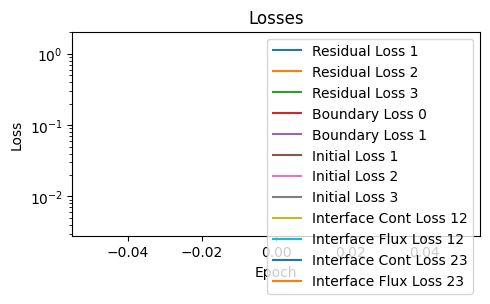

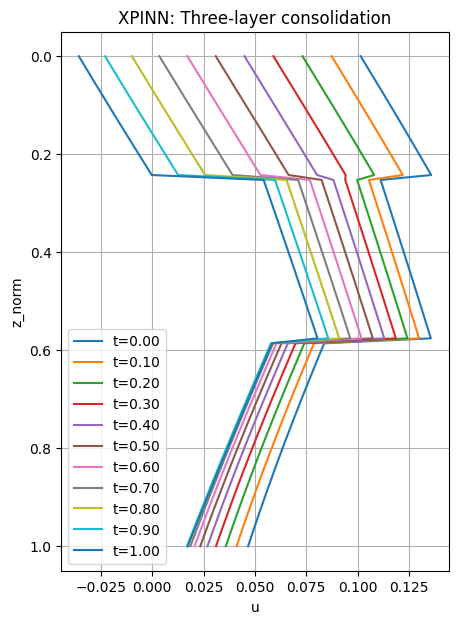

KeyboardInterrupt: 

In [98]:
for epoch in range(adam_epochs):
    optimizer.zero_grad()
    total_loss, parts = compute_total_loss(model1, model2, model3)
    total_loss.backward()
    optimizer.step()

    log_losses(parts)
    best_loss = min(best_loss, total_loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: "
            f"Total Loss: {total_loss.item():.4e},"
            f"Residual Loss 1: {losses['Residual Loss 1'][-1]:.4e}, "
            f"Residual Loss 2: {losses['Residual Loss 2'][-1]:.4e}, "
            f"Residual Loss 3: {losses['Residual Loss 3'][-1]:.4e}, "
            f"Boundary Loss 0: {losses['Boundary Loss 0'][-1]:.4e}, "
            f"Boundary Loss 1: {losses['Boundary Loss 1'][-1]:.4e}, "
            f"Initial Loss 1: {losses['Initial Loss 1'][-1]:.4e}, "
            f"Initial Loss 2: {losses['Initial Loss 2'][-1]:.4e}, "
            f"Initial Loss 3: {losses['Initial Loss 3'][-1]:.4e}, "
            f"Interface Cont Loss 12: {losses['Interface Cont Loss 12'][-1]:.4e}, "
            f"Interface Flux Loss 12: {losses['Interface Flux Loss 12'][-1]:.4e}, "
            f"Interface Cont Loss 23: {losses['Interface Cont Loss 23'][-1]:.4e}, "
            f"Interface Flux Loss 23: {losses['Interface Flux Loss 23'][-1]:.4e} ")

        plot_loss(losses)
        # Save the losses to a file
        np.save("loss_history.npy", losses)

        N_test=100
        # --- testing & plotting ---
        test_t = torch.linspace(0,1,11).view(-1,1)
        z_plot = torch.linspace(0,1,N_test).view(-1,1)

        plt.figure (figsize=(5, 7))
        for t in test_t:
            u_vals= []
            for z in z_plot:
                test_params = torch.cat([
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1)
                                        ], dim=0).view(1,-1)
                test_coords = torch.cat([t.view(1,1), z.view(1,1)], dim=0).view(1,-1)
                with torch.no_grad():
                    if z.item()<=3/12:
                        u_vals.append(model1(test_coords, test_params).item())
                    elif z.item()<=7/12:
                        u_vals.append(model2(test_coords, test_params).item())
                    else:
                        u_vals.append(model3(test_coords, test_params).item())
            plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

        plt.gca().invert_yaxis()
        plt.xlabel("u")
        plt.ylabel("z_norm")
        plt.title("XPINN: Three-layer consolidation")
        plt.legend()
        plt.grid(True)
        plt.show()

print(f"Phase 1 Adam complete. Best loss so far: {best_loss:.4e}")

extra_epochs_adam = 0
while True:
    extra_epochs_adam += 1

    optimizer.zero_grad()
    total_loss, parts = compute_total_loss(model1, model2, model3)
    total_loss.backward()
    optimizer.step()

    log_losses(parts)
    current_loss = total_loss.item()


    # Periodic logging
    if extra_epochs_adam % 100 == 0:
        print(f"Extra Epoch Adam: {extra_epochs_adam}: "
            f"Total Loss: {total_loss.item():.4e},"
            f"Residual Loss 1: {losses['Residual Loss 1'][-1]:.4e}, "
            f"Residual Loss 2: {losses['Residual Loss 2'][-1]:.4e}, "
            f"Residual Loss 3: {losses['Residual Loss 3'][-1]:.4e}, "
            f"Boundary Loss 0: {losses['Boundary Loss 0'][-1]:.4e}, "
            f"Boundary Loss 1: {losses['Boundary Loss 1'][-1]:.4e}, "
            f"Initial Loss 1: {losses['Initial Loss 1'][-1]:.4e}, "
            f"Initial Loss 2: {losses['Initial Loss 2'][-1]:.4e}, "
            f"Initial Loss 3: {losses['Initial Loss 3'][-1]:.4e}, "
            f"Interface Cont Loss 12: {losses['Interface Cont Loss 12'][-1]:.4e}, "
            f"Interface Flux Loss 12: {losses['Interface Flux Loss 12'][-1]:.4e}, "
            f"Interface Cont Loss 23: {losses['Interface Cont Loss 23'][-1]:.4e}, "
            f"Interface Flux Loss 23: {losses['Interface Flux Loss 23'][-1]:.4e} ")
        plot_loss(losses)

    # Stop if we beat the best
    if current_loss < best_loss:
        print(f"Phase Adam complete. New best loss: {current_loss:.4e} after {extra_epochs_adam} extra epochs")
        plot_loss(losses)
        np.save("loss_history.npy", losses)
        break


optimizer = optim.LBFGS(
    list(model1.parameters()) +
    list(model2.parameters()) +
    list(model3.parameters()),
    lr=1e-1,
    max_iter=100,
    # history_size=100,
    # tolerance_grad=1e-5,
    # tolerance_change=1e-9,
    # line_search_fn='strong_wolfe'
)

latest_parts = {}

def lbfgs_closure():
    optimizer.zero_grad()
    loss, parts = compute_total_loss(model1, model2, model3)
    loss.backward()
    latest_parts.clear()
    latest_parts.update({k: v.detach() for k, v in parts.items()})
    return loss

for epoch in range(lbfgs_epochs):
    total_loss = optimizer.step(lbfgs_closure)
    best_loss = min(best_loss, total_loss.item())

    log_losses(latest_parts)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: "
            f"Total Loss: {total_loss.item():.4e},"
            f"Residual Loss 1: {losses['Residual Loss 1'][-1]:.4e}, "
            f"Residual Loss 2: {losses['Residual Loss 2'][-1]:.4e}, "
            f"Residual Loss 3: {losses['Residual Loss 3'][-1]:.4e}, "
            f"Boundary Loss 0: {losses['Boundary Loss 0'][-1]:.4e}, "
            f"Boundary Loss 1: {losses['Boundary Loss 1'][-1]:.4e}, "
            f"Initial Loss 1: {losses['Initial Loss 1'][-1]:.4e}, "
            f"Initial Loss 2: {losses['Initial Loss 2'][-1]:.4e}, "
            f"Initial Loss 3: {losses['Initial Loss 3'][-1]:.4e}, "
            f"Interface Cont Loss 12: {losses['Interface Cont Loss 12'][-1]:.4e}, "
            f"Interface Flux Loss 12: {losses['Interface Flux Loss 12'][-1]:.4e}, "
            f"Interface Cont Loss 23: {losses['Interface Cont Loss 23'][-1]:.4e}, "
            f"Interface Flux Loss 23: {losses['Interface Flux Loss 23'][-1]:.4e} ")

        plot_loss(losses)
        # Save the losses to a file
        np.save("loss_history.npy", losses)

        N_test=100
        # --- testing & plotting ---
        test_t = torch.linspace(0,1,11).view(-1,1)
        z_plot = torch.linspace(0,1,N_test).view(-1,1)

        plt.figure (figsize=(5, 7))
        for t in test_t:
            u_vals= []
            for z in z_plot:
                test_params = torch.cat([
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1)
                                        ], dim=0).view(1,-1)
                test_coords = torch.cat([t.view(1,1), z.view(1,1)], dim=0).view(1,-1)
                with torch.no_grad():
                    if z.item()<=3/12:
                        u_vals.append(model1(test_coords, test_params).item())
                    elif z.item()<=7/12:
                        u_vals.append(model2(test_coords, test_params).item())
                    else:
                        u_vals.append(model3(test_coords, test_params).item())
            plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

        plt.gca().invert_yaxis()
        plt.xlabel("u")
        plt.ylabel("z_norm")
        plt.title("XPINN: Three-layer consolidation")
        plt.legend()
        plt.grid(True)
        plt.show()

print(f"Phase 1 LBFGS complete. Best loss so far: {best_loss:.4e}")

extra_epochs_lbfgs = 0
while True:
    extra_epochs_lbfgs += 1
    total_loss = optimizer.step(lbfgs_closure)

    log_losses(latest_parts)

    if extra_epochs_lbfgs % 10 == 0:
        print(f"Epoch {extra_epochs_lbfgs}: "
            f"Total Loss: {total_loss.item():.4e},"
            f"Residual Loss 1: {losses['Residual Loss 1'][-1]:.4e}, "
            f"Residual Loss 2: {losses['Residual Loss 2'][-1]:.4e}, "
            f"Residual Loss 3: {losses['Residual Loss 3'][-1]:.4e}, "
            f"Boundary Loss 0: {losses['Boundary Loss 0'][-1]:.4e}, "
            f"Boundary Loss 1: {losses['Boundary Loss 1'][-1]:.4e}, "
            f"Initial Loss 1: {losses['Initial Loss 1'][-1]:.4e}, "
            f"Initial Loss 2: {losses['Initial Loss 2'][-1]:.4e}, "
            f"Initial Loss 3: {losses['Initial Loss 3'][-1]:.4e}, "
            f"Interface Cont Loss 12: {losses['Interface Cont Loss 12'][-1]:.4e}, "
            f"Interface Flux Loss 12: {losses['Interface Flux Loss 12'][-1]:.4e}, "
            f"Interface Cont Loss 23: {losses['Interface Cont Loss 23'][-1]:.4e}, "
            f"Interface Flux Loss 23: {losses['Interface Flux Loss 23'][-1]:.4e} ")

        plot_loss(losses)

        N_test=100
        # --- testing & plotting ---
        test_t = torch.linspace(0,1,11).view(-1,1)
        z_plot = torch.linspace(0,1,N_test).view(-1,1)

        plt.figure (figsize=(5, 7))
        for t in test_t:
            u_vals= []
            for z in z_plot:
                test_params = torch.cat([
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), 
                                        torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1), torch.tensor([[0.0]]).view(1,1)
                                        ], dim=0).view(1,-1)
                test_coords = torch.cat([t.view(1,1), z.view(1,1)], dim=0).view(1,-1)
                with torch.no_grad():
                    if z.item()<=3/12:
                        u_vals.append(model1(test_coords, test_params).item())
                    elif z.item()<=7/12:
                        u_vals.append(model2(test_coords, test_params).item())
                    else:
                        u_vals.append(model3(test_coords, test_params).item())
            plt.plot(u_vals, z_plot.numpy(), label=f't={t.item():.2f}')

        plt.gca().invert_yaxis()
        plt.xlabel("u")
        plt.ylabel("z_norm")
        plt.title("XPINN: Three-layer consolidation")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    if total_loss < best_loss:
        print(f"Phase LBFGS complete. Best loss: {total_loss:.4e} after {extra_epochs_lbfgs} extra epochs")
        plot_loss(losses)
        np.save("loss_history.npy", losses)
        break

In [99]:
model_dir = "Trained models/terzaghi"

In [100]:
import os
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "all_plain.pt")

if os.path.exists(model_path):
    overwrite = input(f"File {model_path} already exists. Overwrite? (yes/no): ")
    if overwrite.strip().lower() not in ["yes", "y"]:
        print("❌ File not overwritten.")
    else:
        torch.save({
            "model1": model1.state_dict(),
            "model2": model2.state_dict(),
            "model3": model3.state_dict(),
        }, model_path)
        print("✅ Saved to:", model_path)
else:
    torch.save({
        "model1": model1.state_dict(),
        "model2": model2.state_dict(),
        "model3": model3.state_dict(),
    }, model_path)
    print("✅ Saved to:", model_path)

❌ File not overwritten.


In [101]:
# 2) Re-instantiate three independent PINNs
PINN1 = cPINN_3layer_terzaghi()
PINN2 = cPINN_3layer_terzaghi()
PINN3 = cPINN_3layer_terzaghi()

# 3) Load the checkpoint (no weights_only arg!)
ckpt = torch.load(
    os.path.join(model_dir, "all_plain.pt"),
    weights_only=True)

# 4) Copy the weights back in
PINN1.load_state_dict(ckpt["model1"])
PINN2.load_state_dict(ckpt["model2"])
PINN3.load_state_dict(ckpt["model3"])
print("✅ Loaded PINN1, PINN2, PINN3 from checkpoint")

✅ Loaded PINN1, PINN2, PINN3 from checkpoint


In [102]:
def terzaghi_PINN_eval(values, PINN1, PINN2, PINN3, multiplier, record_times, Nz):
    """Evaluate the three-layer Terzaghi model at the given values."""
    H1_raw, k1_raw, mv1_raw, H2_raw, k2_raw, mv2_raw, H3_raw, k3_raw, mv3_raw = values

    #normalize the values
    H1_norm = (H1_raw - specs["H1"]["mean"]) / (specs["H1"]["std"]*multiplier)  
    H2_norm = (H2_raw - specs["H2"]["mean"]) / (specs["H2"]["std"]*multiplier)
    H3_norm = (H3_raw - specs["H3"]["mean"]) / (specs["H3"]["std"]*multiplier)
    k1_norm = (k1_raw - specs["k1"]["mean"]) / (specs["k1"]["std"]*multiplier)
    k2_norm = (k2_raw - specs["k2"]["mean"]) / (specs["k2"]["std"]*multiplier)
    k3_norm = (k3_raw - specs["k3"]["mean"]) / (specs["k3"]["std"]*multiplier)
    mv1_norm = (mv1_raw - specs["mv1"]["mean"]) / (specs["mv1"]["std"]*multiplier)
    mv2_norm = (mv2_raw - specs["mv2"]["mean"]) / (specs["mv2"]["std"]*multiplier)
    mv3_norm = (mv3_raw - specs["mv3"]["mean"]) / (specs["mv3"]["std"]*multiplier)


    H_tot  = H1_raw + H2_raw + H3_raw

    h1_frac = H1_raw / H_tot               # boundary between layer1 & 2
    h2_frac = (H1_raw + H2_raw) / H_tot    # boundary between layer2 & 3

    test_t = torch.tensor(record_times, dtype=torch.float32).view(-1, 1)/10   # 11 time snapshots
    z   = torch.linspace(0,1,Nz).view(-1,1)    # 100 points in z_norm
                      # (N,1)
    k1_batch     = torch.full_like(z, k1_norm)
    k2_batch     = torch.full_like(z, k2_norm)
    k3_batch     = torch.full_like(z, k3_norm)
    mv1_batch    = torch.full_like(z, mv1_norm)
    mv2_batch    = torch.full_like(z, mv2_norm)
    mv3_batch    = torch.full_like(z, mv3_norm)
    H1_batch     = torch.full_like(z, H1_norm)
    H2_batch     = torch.full_like(z, H2_norm)
    H3_batch     = torch.full_like(z, H3_norm)

    test_params = torch.cat([
        H1_batch, k1_batch, mv1_batch,
        H2_batch, k2_batch, mv2_batch,
        H3_batch, k3_batch, mv3_batch
    ], dim=1) 

    plt.figure(figsize=(5,7))

    u = torch.zeros((11,Nz), dtype=torch.float32) 

    for i,t in enumerate(test_t):
        # a) batch coords & params
        t_batch      = t.repeat(Nz,1)                 

        test_coords = torch.cat([t_batch, z], dim=1)

        with torch.no_grad():
            zb = z.squeeze()              # shape (N,)
            mask1 = zb <= h1_frac
            mask2 = (zb > h1_frac) & (zb <= h2_frac)
            mask3 = zb > h2_frac

            # 1) Layer 1
            if mask1.any():
                coords1 = test_coords[mask1]
                params1 = test_params[mask1]
                u1 = PINN1(coords1, params1).squeeze()
                u[i, mask1] = u1

            # 2) Layer 2
            if mask2.any():
                coords2 = test_coords[mask2]
                params2 = test_params[mask2]
                u2 = PINN2(coords2, params2).squeeze()
                u[i, mask2] = u2

            # 3) Layer 3
            if mask3.any():
                coords3 = test_coords[mask3]
                params3 = test_params[mask3]
                u3 = PINN3(coords3, params3).squeeze()
                u[i, mask3] = u3

    return u

In [103]:
def fd_terzaghi_3layer(values, record_times, Nz):
    """ input: values = [k1, k2, k3, mv1, mv2, mv3, H1, H2, H3]
        record_times = np.linspace(0, T, 11)
        output: snapshots = {t: u(z,t) for t in record_times}"""

    H1, k1, mv1, H2, k2, mv2, H3, k3, mv3 = values

    γw  = 9.81        # kN/m³
    H   = H1 + H2 + H3       # m         (total thickness)
    z1, z2 = H1, H2+H1                 # 3 m, 7 m is mean
    T   = 10.0        # yr        (total time span)

    # -------------------------------------------------------------
    # 2)  spatial grid  z ∈ [0,H]  (physical metres)
    # -------------------------------------------------------------
    z    = np.linspace(0.0, H, Nz)
    dz   = z[1] - z[0]

    z1, z2 = H1, H2+H1                 # 3 m, 7 m is mean
    idx1, idx2 = np.searchsorted(z, [z1, z2])

    # layer-wise k(z) and m_v(z)
    k_layer  = np.empty(Nz)
    mv_layer = np.empty(Nz)

    k_layer[:idx1]      = k1
    k_layer[idx1:idx2]  = k2
    k_layer[idx2:]      = k3

    mv_layer[:idx1]     = mv1
    mv_layer[idx1:idx2] = mv2
    mv_layer[idx2:]     = mv3

    # harmonic mean of k at faces
    k_half = 2.0 * k_layer[:-1] * k_layer[1:] / (k_layer[:-1] + k_layer[1:])

    # -------------------------------------------------------------
    # 3)  explicit CFL time step
    # -------------------------------------------------------------
    cv_layer = k_layer / (mv_layer * γw)        # m²/yr
    cv_max   = cv_layer.max()
    dt       = 0.49 * dz**2 / cv_max           # yr   (≈ 2·10⁻⁵)
    Nt       = int(np.ceil(T / dt)) + 1
    print(f"Δt = {dt:.3e} yr   →   Nt = {Nt:,d} steps")

    # times to record (years) and a lookup dict for fast checks
    record_steps  = {int(t/dt): t for t in record_times}
    snapshots     = {}

    # -------------------------------------------------------------
    # 4)  initial & boundary conditions
    # -------------------------------------------------------------
    u = np.ones(Nz)
    u[0]  = 0.0             # drained top: u = 0
    u[-1] = u[-2]           # impermeable bottom: ∂u/∂z = 0

    # -------------------------------------------------------------
    # 5)  explicit time march
    # -------------------------------------------------------------
    for n in range(Nt):
        # Darcy flux  F[i+½] = k_half * (u[i+1]-u[i]) / dz
        F = k_half * (u[1:] - u[:-1]) / dz

        # update interior nodes  m_v γ_w ∂u/∂t = ∂F/∂z
        u_new = u.copy()
        u_new[1:-1] += (dt / (mv_layer[1:-1] * γw * dz)) * (F[1:] - F[:-1])

        # re-apply BCs
        u_new[0]  = 0.0
        u_new[-1] = u_new[-2]

        u = u_new

        # record snapshots
        if n in record_steps:
            snapshots[record_steps[n]] = u.copy()
    return snapshots

Δt = 4.708e-04 yr   →   Nt = 21,241 steps
0 0.0
1 2.5
2 5.0
3 7.5
4 10.0


<Figure size 500x700 with 0 Axes>

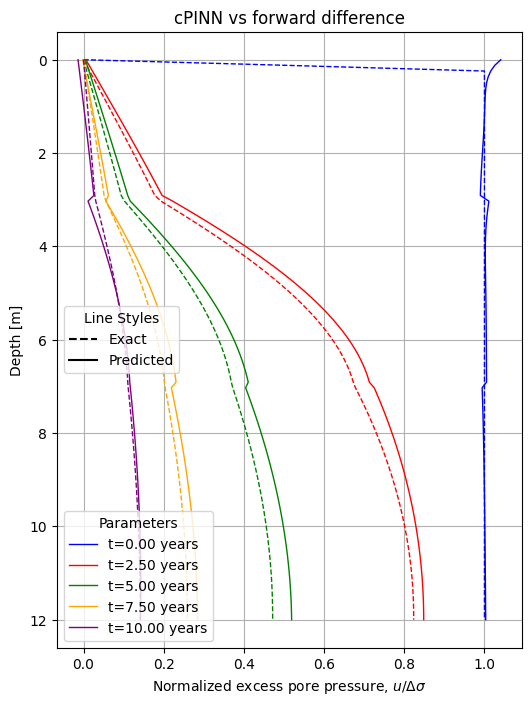

dict_keys([0.0, 2.5, 5.0, 7.5, 10.0])


In [148]:
height_test = .0
k_test = 1.0
mv_test = -1.0
Nz = 100

k1  = 2.0e-2 + 2e-3 * k_test * multiplier   # m/yr
k2  = 6.0e-3 + 6e-4 * k_test * multiplier
k3  = 3.0e-3 + 3e-4 * k_test * multiplier
mv1 = 4.0e-4 + 4e-5 * mv_test * multiplier  # m²/kN
mv2 = 6.0e-4 + 6e-5 * mv_test * multiplier
mv3 = 7.0e-5 + 7e-6 * mv_test * multiplier
H1 = 3 + 0.15 * height_test * multiplier  # m
H2 = 4 + 0.2 * height_test * multiplier
H3 = 5 + 0.25 * height_test * multiplier

values=[H1, k1, mv1,
        H2, k2, mv2,
        H3, k3, mv3]

record_times = np.linspace(0.0, 10.0, 5)  # years
z_plot = np.linspace(0, H1+H2+H3, Nz) 
snapshots = fd_terzaghi_3layer(values, record_times, Nz)

u = terzaghi_PINN_eval(
    values=values,
    PINN1=PINN1,
    PINN2=PINN2,
    PINN3=PINN3,
    multiplier=multiplier,
    record_times=record_times,
    Nz=Nz
)


plt.figure(figsize=(6,8))
# plot all t-slices
colors = ['blue', 'red', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan', 'magenta']
for i, t in enumerate(record_times):
    plt.plot(u[i], z_plot, color=colors[i], label=f't={t:.2f} years', linewidth=1)
    print(i,t)
    plt.plot(snapshots[t], z_plot, linestyle='--', color=colors[i], linewidth=1)

plt.gca().invert_yaxis()
plt.xlabel("Normalized excess pore pressure, $u/\Delta\sigma$")
plt.ylabel("Depth [m]")
plt.title("cPINN vs forward difference")
plt.legend()
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='center left', title='Line Styles')

plt.show()
print(snapshots.keys())

In [156]:
# 7) integrate in normalized z (0→1)
integral_norm = np.trapz(snapshots[10.0], z_plot)  # (B,)

# 8) multiply by each sample’s total H
integral_phys = integral_norm * (H1 + H2 + H3) # (B,)

print(integral_phys)

12.193779932857398


# Probability algorithm

In [105]:
print(specs)

{'t': {'range': 10.0}, 'k1': {'mean': 0.02, 'std': 0.002, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'k2': {'mean': 0.006, 'std': 0.0006, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'k3': {'mean': 0.003, 'std': 0.0003, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'mv1': {'mean': 0.0004, 'std': 4e-05, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'mv2': {'mean': 0.0006, 'std': 6e-05, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'mv3': {'mean': 7e-05, 'std': 7e-06, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'H1': {'mean': 3.0, 'std': 0.15, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'H2': {'mean': 4.0, 'std': 0.2, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}, 'H3': {'mean': 5.0, 'std': 0.25, 'lower_multiplier': -5.0, 'upper_multiplier': 5.0}}


In [106]:
from scipy.stats import qmc

def initial_MCMC_samples(specs, num_initial_samples=10, seed=42):
    # 1) fix the order of your parameters
    param_list = ['H1','k1','mv1','H2','k2','mv2','H3','k3','mv3']
    
    # 2) draw the unit hypercube sample
    sampler = qmc.LatinHypercube(d=len(param_list), seed=seed)
    unit_pts = sampler.random(num_initial_samples)  # shape (N,9)
    initial_samples = np.zeros((num_initial_samples, len(param_list)))
    
    for i, param in enumerate(param_list):
        mean = specs[param]['mean']
        std = specs[param]['std']
        lower_bound = mean + specs[param]['lower_multiplier'] * std
        upper_bound = mean + specs[param]['upper_multiplier'] * std
        initial_samples[:, i] = unit_pts[:, i] * (upper_bound - lower_bound) + lower_bound
    
    return initial_samples

In [ ]:
def make_input_params_batched(z_coll, values, specs, multiplier):
    """
    Makes batched test parameters for input to the PINN model.

    Args:
      z_coll:  torch.Tensor of shape (Nz,) or array-like
      values:  torch.Tensor shape (9,), or (B,9)

    Returns:
      Tuple of 9 torch.Tensors, each of shape (B, Nt, 1).
    """
    Nz = z_coll.shape[0]

    values = values.clone() # make a copy to avoid modifying the original

    # If it’s 1D-length-9, make it shape (1,9)
    if values.dim() == 1:
        values = values.unsqueeze(0)

    B = values.shape[0]
    if values.shape[1] != 9:
        raise ValueError(f"Expected second dim of size 9, got {values.shape}")

    # normalize the values
    for i, param in enumerate(['H1','k1','mv1','H2','k2','mv2','H3','k3','mv3']):
        values[:, i] = (values[:,i] - specs[param]['mean'])/(specs[param]['std']*multiplier)  

    # 4) Expand each scalar to (B, Nz, 1)
    # values[:,i] is (B,)
    H1  = values[:, 0][:, None, None].expand(B, Nz, 1)
    k1  = values[:, 1][:, None, None].expand(B, Nz, 1)
    mv1 = values[:, 2][:, None, None].expand(B, Nz, 1)
    H2  = values[:, 3][:, None, None].expand(B, Nz, 1)
    k2  = values[:, 4][:, None, None].expand(B, Nz, 1)
    mv2 = values[:, 5][:, None, None].expand(B, Nz, 1)
    H3  = values[:, 6][:, None, None].expand(B, Nz, 1)
    k3  = values[:, 7][:, None, None].expand(B, Nz, 1)
    mv3 = values[:, 8][:, None, None].expand(B, Nz, 1)

    return H1, k1, mv1, H2, k2, mv2, H3, k3, mv3

In [176]:
# import torch

# def limit_state_function_G_batched(
#     model1: torch.nn.Module,
#     model2: torch.nn.Module,
#     model3: torch.nn.Module,
#     z_coll:   torch.Tensor,        # (Nz,)   – normalised depth 0…1
#     pred_params: tuple,           # 9 tensors, each (B, Nz, 1)
#     settlement_limit: float = 0.40,   # [m]
# ) -> torch.Tensor:
#     """
#     Vectorised limit-state evaluation.

#     Parameters
#     ----------
#     model1/2/3 :   cPINN models for layers 1–3.
#     z_vec      :   (Nz,)  normalised depths (0 … 1) or physical [m].
#     pred_params:   tuple (H1,k1,mv1,H2,k2,mv2,H3,k3,mv3) each (B, Nz, 1).
#                    These are *already* expanded in (B,Nz,1) form.
#     dz_physical:   Physical thickness H   if z_vec is normalised;
#                    otherwise leave at 1 and supply physical z_vec.
#     settlement_target : settlement at which G=0  (e.g. 0.40 m)

#     Returns
#     -------
#     G : (B,) torch tensor
#     """
#     # ---------------------------------------
#     # 0) unpack and form convenience scalars
#     # ---------------------------------------
#     H1,k1,mv1,H2,k2,mv2,H3,k3,mv3 = pred_params      # (B,Nz,1)

#     B, Nz, _ = H1.shape
#     z_batch  = z_coll.view(1, Nz, 1).expand(B, -1, -1)        # (B,Nz,1)
#     t_batch  = torch.ones_like(z_batch)                      # (B,Nz,1), t*=1

#     # global coords & params    (B,Nz,2)  /  (B,Nz,9)
#     coords   = torch.cat([t_batch, z_batch], dim=-1)
#     params   = torch.cat([H1,k1,mv1,H2,k2,mv2,H3,k3,mv3], dim=-1)

#     # layer boundaries for each sample b
#     # h1 = H1 / Htot,   h2 = (H1+H2)/Htot
#     Htot     = (H1[:,0,0] + H2[:,0,0] + H3[:,0,0]).unsqueeze(-1)   # (B,1)
#     h1_frac  = (H1[:,0,0]/Htot).unsqueeze(-1)                      # (B,1)
#     h2_frac  = ((H1[:,0,0]+H2[:,0,0])/Htot).unsqueeze(-1)          # (B,1)

#     # broadcast to (B,Nz)
#     z_batched   = z_coll.view(1, Nz).expand(B, Nz)

#     mask1 = (z_batched <= h1_frac)                       # (B,Nz) bool
#     mask2 = (z_batched >  h1_frac) & (z_batched <= h2_frac)
#     mask3 = (z_batched >  h2_frac)

#     # ---------------------------------------
#     # 1) run the three sub-nets
#     # ---------------------------------------
#     with torch.no_grad():
#         # flatten helpers
#         def flat_select(t, m):          # t:(B,Nz,K), m:(B,Nz) bool
#             t_flat = t.view(-1, t.shape[-1])
#             m_flat = m.reshape(-1)
#             return t_flat[m_flat]

#         # Layer-1
#         idx1 = mask1.reshape(-1)
#         u1   = model1( flat_select(coords, mask1),
#                        flat_select(params, mask1) ).squeeze()

#         # Layer-2
#         u2   = model2( flat_select(coords, mask2),
#                        flat_select(params, mask2) ).squeeze()

#         # Layer-3
#         u3   = model3( flat_select(coords, mask3),
#                        flat_select(params, mask3) ).squeeze()

#         # -----------------------------------
#         # 2) scatter back into (B,Nz)
#         # -----------------------------------
#         u_flat = torch.empty(B*Nz)
#         u_flat[idx1]                   = u1
#         u_flat[mask2.reshape(-1)]      = u2
#         u_flat[mask3.reshape(-1)]      = u3
#         u = u_flat.view(B, Nz)         # (B,Nz)

#     # ---------------------------------------
#     # 3) integrate   ∫ u(z) dz  in ζ-space
#     # ---------------------------------------
#     integral_norm = torch.trapz(u, z_coll, dim=1)      # (B,)

#     # multiply by each sample's physical thickness
#     integral_phys = integral_norm * Htot.squeeze(-1)  # (B,)

#     # ---------------------------------------
#     # 4) limit-state value
#     # ---------------------------------------
#     G = integral_phys - settlement_limit             # (B,)
#     return G

# def limit_state_function_G_batched(
#     model1, model2, model3,
#     z_vec,            # torch.Tensor shape (Nz,)
#     pred_params,      # tuple of 9 tensors, each (B, Nz, 1)
#     specs,
#     multiplier,
#     settlement_limit=0.40
# ):
#     """
#     Returns G (B,) = [∫_0^H u(z) dz] - settlement_limit,
#     for a batch of B param‐sets, each evaluated over Nz depths.
#     """
#     # Unpack
#     H1, k1, mv1, H2, k2, mv2, H3, k3, mv3 = pred_params  # each (B,Nz,1)
#     B, Nz, _ = H1.shape

#     # Make phsyical values 
#     H1_phys = H1 * specs["H1"]["std"] * multiplier + specs["H1"]["mean"]
#     H2_phys = H2 * specs["H2"]["std"] * multiplier + specs["H2"]["mean"]
#     H3_phys = H3 * specs["H3"]["std"] * multiplier + specs["H3"]["mean"]
#     mv1_phys = mv1 * specs["mv1"]["std"] * multiplier + specs["mv1"]["mean"]
#     mv2_phys = mv2 * specs["mv2"]["std"] * multiplier + specs["mv2"]["mean"]
#     mv3_phys = mv3 * specs["mv3"]["std"] * multiplier + specs["mv3"]["mean"]

#     # 1) build coords_flat (B*Nz,2) and params_flat (B*Nz,9)
#     #    z_vec must be 1-D: (Nz,)
#     z_norm = z_vec.view(1, Nz, 1).expand(B, Nz, 1)    # (B,Nz,1)
#     t_norm = torch.ones_like(z_norm)                  # t* = 1 for all
#     coords  = torch.cat([t_norm, z_norm], dim=2)      # (B,Nz,2)
#     params  = torch.cat(
#         [H1, k1, mv1, H2, k2, mv2, H3, k3, mv3],
#         dim=2
#     )                                                 # (B,Nz,9)

#     coords_flat = coords.reshape(-1, 2)               # (B*Nz, 2)
#     params_flat = params.reshape(-1, 9)               # (B*Nz, 9)

#     # 2) compute per-sample layer boundaries
#     Htot     = (H1[:, 0, 0] + H2[:, 0, 0] + H3[:, 0, 0]).unsqueeze(1)       # (B,1)
#     h1   = (H1[:, 0, 0] / Htot).unsqueeze(1)           # (B,1)
#     h2   = ((H1[:, 0, 0] + H2[:, 0, 0]) / Htot).unsqueeze(1)  # (B,1)

#     # 3) flatten z_norm into a vector (B*Nz,)
#     z_flat = z_norm.reshape(B, Nz, 1)[:,:,0].reshape(-1)  # (B*Nz,)

#     # 4) build boolean masks in flat space
#     #    we need h1,h2 repeated across depth:
#     h1_flat = h1.expand(B, Nz).reshape(-1)   # (B*Nz,)
#     h2_flat = h2.expand(B, Nz).reshape(-1)   # (B*Nz,)

#     mask1 = z_flat <= h1_flat
#     mask2 = (z_flat >  h1_flat) & (z_flat <= h2_flat)
#     mask3 = z_flat >  h2_flat

#     # 5) allocate flat output and eval each net exactly on its mask
#     u_flat = torch.empty(B * Nz)
#     mv_phys_flat = torch.empty(B*Nz )

#     with torch.no_grad():
#         if mask1.any():
#             u_flat[mask1] = model1(
#                 coords_flat[mask1],
#                 params_flat[mask1]
#             mv_phys_flat[mask1] = 
#             ).squeeze()
#         if mask2.any():
#             u_flat[mask2] = model2(
#                 coords_flat[mask2],
#                 params_flat[mask2]
#             mv_phys_flat[mask2] =
#             ).squeeze()
#         if mask3.any():
#             u_flat[mask3] = model3(
#                 coords_flat[mask3],
#                 params_flat[mask3]
#             mv_phys_flat[mask3] =
#             ).squeeze()

#     # 6) reshape back to (B,Nz)
#     u = u_flat.view(B, Nz)    # (B, Nz)
#     mv_grid = mv_phys_flat.view(B, Nz)  # (B, Nz)

#     # 7) integrate in normalized z (0→1)
#     integral_norm = torch.trapz(u*mv_grid, z_vec, dim=1)  # (B,)

#     # 8) multiply by each sample’s total H
#     Htot_phys = (H1_phys[:, 0, 0] + H2_phys[:, 0, 0] + H3_phys[:, 0, 0])   # (B,)
#     integral_phys = integral_norm * Htot_phys          # (B,)

#     # 9) limit-state: G = ∫u dz − settlement_limit
#     G = integral_phys - settlement_limit          # (B,)
#     return G

import torch

def limit_state_function_G_batched(
    model1, model2, model3,
    z_vec,            # torch.Tensor shape (Nz,)
    pred_params,      # tuple of 9 tensors, each (B, Nz, 1)
    specs,
    multiplier,
    settlement_limit=0.40
):
    """
    Returns G (B,) = [∫_0^H mv(z)*u(z) dz] - settlement_limit,
    for a batch of B param‐sets, each evaluated over Nz depths.
    """
    # Unpack normalized params (B, Nz, 1)
    H1, k1, mv1, H2, k2, mv2, H3, k3, mv3 = pred_params
    B, Nz, _ = H1.shape
    device = H1.device

    # Reconstruct *physical* H and mv (B, Nz, 1)
    H1_phys  = H1  * specs["H1"]["std"]  * multiplier + specs["H1"]["mean"]
    H2_phys  = H2  * specs["H2"]["std"]  * multiplier + specs["H2"]["mean"]
    H3_phys  = H3  * specs["H3"]["std"]  * multiplier + specs["H3"]["mean"]
    mv1_phys = mv1 * specs["mv1"]["std"] * multiplier + specs["mv1"]["mean"]
    mv2_phys = mv2 * specs["mv2"]["std"] * multiplier + specs["mv2"]["mean"]
    mv3_phys = mv3 * specs["mv3"]["std"] * multiplier + specs["mv3"]["mean"]
    Htot_phys = (
        H1_phys[:, 0, 0]+
        H2_phys[:, 0, 0]+
        H3_phys[:, 0, 0]
    )  # shape: (B,)

    # 1) build the (B*Nz,2) coords_flat and (B*Nz,9) params_flat_norm
    z_norm      = z_vec.view(1, Nz, 1).expand(B, Nz, 1)   # (B,Nz,1)
    t_norm      = torch.ones_like(z_norm)                 # t*=1
    coords      = torch.cat([t_norm, z_norm], dim=2)      # (B,Nz,2)
    params_norm = torch.cat(
        [H1, k1, mv1, H2, k2, mv2, H3, k3, mv3],
        dim=2
    )                                                    # (B,Nz,9)

    coords_flat   = coords.reshape(-1, 2)                 # (B*Nz,2)
    params_flat   = params_norm.reshape(-1, 9)            # (B*Nz,9)

    # also flatten the physical mv arrays
    mv1_phys_flat = mv1_phys.reshape(-1)                  # (B*Nz,)
    mv2_phys_flat = mv2_phys.reshape(-1)
    mv3_phys_flat = mv3_phys.reshape(-1)

    # 2) compute per-sample layer fractions as 1-D
    Htot    = (H1[:,0,0] + H2[:,0,0] + H3[:,0,0])   # -> (B,)
    h1_frac = H1[:,0,0] / Htot                      # -> (B,)
    h2_frac = (H1[:,0,0] + H2[:,0,0]) / Htot        # -> (B,)

    # 3) flatten the normalized depth to (B*Nz,)
    z_flat = z_norm.reshape(-1)

    # 4) expand h1_frac,h2_frac to (B,Nz) then flatten → (B*Nz,)
    h1_flat = h1_frac.unsqueeze(1).expand(B, Nz).reshape(-1)
    h2_flat = h2_frac.unsqueeze(1).expand(B, Nz).reshape(-1)

    mask1 = z_flat <=  h1_flat
    mask2 = (z_flat >  h1_flat) & (z_flat <= h2_flat)
    mask3 = z_flat >  h2_flat

    # 5) eval u_flat and mv_phys_flat via masking
    u_flat       = torch.empty(B*Nz, device=device)
    mv_phys_flat = torch.empty(B*Nz, device=device)

    with torch.no_grad():
        # Layer 1
        if mask1.any():
            u_flat[mask1]        = model1(
                coords_flat[mask1],
                params_flat[mask1]
            ).squeeze()
            mv_phys_flat[mask1]  = mv1_phys_flat[mask1]

        # Layer 2
        if mask2.any():
            u_flat[mask2]        = model2(
                coords_flat[mask2],
                params_flat[mask2]
            ).squeeze()
            mv_phys_flat[mask2]  = mv2_phys_flat[mask2]

        # Layer 3
        if mask3.any():
            u_flat[mask3]        = model3(
                coords_flat[mask3],
                params_flat[mask3]
            ).squeeze()
            mv_phys_flat[mask3]  = mv3_phys_flat[mask3]

    # 6) reshape back to (B, Nz)
    u_grid    = u_flat.view(B, Nz)
    mv_grid   = mv_phys_flat.view(B, Nz)

    # 7) integrate in normalized z then scale by each sample’s H_tot_phys

    integral_norm = torch.trapz(u_grid * mv_grid, z_vec, dim=1)  # (B,)
    integral_phys = integral_norm * Htot_phys                         # (B,)

    # 8) limit-state
    G = settlement_limit- integral_phys*100                         # (B,)
    return G

In [179]:
num_initial_samples = 10
num_samples = 1
burn_in = 0
Nz = 4
proposal_scale = 0.2
z_coll = torch.linspace(0, 1, Nz)  # (Nz, 1)
sigma_hat_e = None

u_curr = initial_MCMC_samples(specs, num_initial_samples)
u_prop = np.copy(u_curr)
accepted_count = 0
# z_batch=z_coll.view(1, z_coll.shape[0], 1).expand(u_prop.shape[0], z_coll.shape[0], 1)  # (B, Nz, 1)
if sigma_hat_e is None:
    sigma_hat_e = 0.01 * np.std(u_curr)   # Initial guess - must be improved later 
accepted_samples = np.zeros((num_samples, num_initial_samples, u_curr.shape[1]))

for i in range(num_samples+burn_in):
    # Generate a new sample from the proposal distribution
    for j, param in enumerate(['H1','k1','mv1','H2','k2','mv2','H3','k3','mv3']):
        lb = specs[param]['mean'] + specs[param]['lower_multiplier'] * specs[param]['std']
        ub = specs[param]['mean'] + specs[param]['upper_multiplier'] * specs[param]['std']
        
        u_prop[:, j] = np.random.normal(loc=u_curr[:, j], scale=proposal_scale*specs[param]['std'], size=u_curr.shape[0])

    # Evaluate the limit state function G(x) for the proposal sample
    input_to_g_prop = make_input_params_batched(z_coll, torch.from_numpy(u_prop).float(), specs, multiplier)

    u_excess = limit_state_function_G_batched(
        model1=model1,
        model2=model2,
        model3=model3,
        z_vec=z_coll,
        pred_params=input_to_g_prop,
        specs=specs,
        multiplier=multiplier,
        settlement_limit=0.40
    )
print(u_excess)

tensor([ 0.3205,  0.3366,  0.0896,  0.1062,  0.0940, -0.1506,  0.2170,  0.3451,
         0.1823,  0.2615])


In [ ]:
def metropolis_hastings(PINN1, PINN2, PINN3, multiplier, z_coll, num_samples, burn_in, num_initial_samples, norm_info, specs, sigma_hat_e=None, proposal_scale = 1):

    u_curr = initial_MCMC_samples(specs, num_initial_samples)
    u_prop = np.copy(u_curr)
    accepted_count = 0
    # z_batch=z_coll.view(1, z_coll.shape[0], 1).expand(u_prop.shape[0], z_coll.shape[0], 1)  # (B, Nz, 1)
    if sigma_hat_e is None:
        sigma_hat_e = 0.01 * np.std(u_curr)   # Initial guess - must be improved later 
    accepted_samples = np.zeros((num_samples, num_initial_samples, u_curr.shape[1]))

    for i in range(num_samples+burn_in):
        # Generate a new sample from the proposal distribution
        for j, param in enumerate(['H1','k1','mv1','H2','k2','mv2','H3','k3','mv3']):
            u_prop[:, j] = np.random.normal(loc=u_curr[:, j], scale=proposal_scale*specs[param]['std'], size=u_curr.shape[0])

        # Evaluate the limit state function G(x) for the proposal sample
        input_to_g_prop = make_input_params_batched(z_coll, torch.from_numpy(u_prop).float(), specs, multiplier)
        
        g_hat_prop = limit_state_function_G_batched(
            PINN1,
            PINN2,
            PINN3,
            z_coll,
            input_to_g_prop
        ).detach() # detach() to avoid gradients = True 

        # Evaluate the limit state function G(x) for the current sample
        input_to_G_curr = make_input_params_batched(z_coll, torch.from_numpy(u_curr).float(), norm_info)

        g_hat_curr = limit_state_function_G_batched(
            PINN1,
            PINN2,
            PINN3,
            z_coll,
            input_to_G_curr
        ).detach() # detach() to avoid gradients = True

        # Evaluate the pdf values for the current and proposal samples
        pdf_curr = pdf_value(u_curr, norm_info)
        pdf_prop = pdf_value(u_prop, norm_info)

        # Evaluate the pi-function for the proposal and current samples
        pi_prop= norm.cdf(-g_hat_prop/sigma_hat_e)
        pi_curr= norm.cdf(-g_hat_curr/sigma_hat_e)

        # Evaluate the h-function for the proposal and current samples
        h_prop = pi_prop * pdf_prop
        h_curr = pi_curr * pdf_curr

        alpha = h_prop / h_curr

        # Accept or reject the proposal based on the acceptance ratio
        rand = np.random.rand(num_initial_samples)
        accept = alpha > rand
        u_curr = np.where(accept[:, None], u_prop, u_curr)

        if i >= burn_in:
            accepted_count += np.sum(accept) # total number of accepted proposals, not stored samples
            accepted_samples[i - burn_in] = u_curr            

    return accepted_samples, accepted_count

In [111]:
num_initial_samples = 10
num_samples = 10
sigma_hat_e = None
proposal_scale = 0.2
burn_in = 10



In [112]:
from scipy.integrate import simpson 
def total_settlement(u_vals, values):

    H_tot = values[0] + values[3] + values[6]
    
    z_vals = np.linspace(0, H_tot, len(u_vals))
    
    # Effective stress = delta_sigma - u
    effective_stress = 1 - u_vals

    # Integrate effective stress over depth to get strain, then multiply by mv
    settlement = mv * simpson(effective_stress, x=z_vals)  # or np.trapz

    return settlement

In [113]:
total_settlement_1 = total_settlement(snapshots[record_times[10]], values)*100
print(total_settlement_1)

NameError: name 'mv' is not defined

# End

It: 0, Loss1: 3.398e+02, Loss2: 2.318e+00, Loss3: 1.359e+01, L2_err2: 1.064e+00, L2_err3: 1.047e+00
It: 20, Loss1: 2.741e+02, Loss2: 1.899e+00, Loss3: 1.259e+01, L2_err2: 1.062e+00, L2_err3: 9.574e-01
It: 40, Loss1: 1.863e+02, Loss2: 2.471e+00, Loss3: 1.287e+01, L2_err2: 6.897e-01, L2_err3: 7.309e-01
It: 60, Loss1: 8.981e+01, Loss2: 3.680e+00, Loss3: 1.553e+01, L2_err2: 1.433e-01, L2_err3: 3.249e-01
It: 80, Loss1: 4.685e+01, Loss2: 3.375e+00, Loss3: 1.569e+01, L2_err2: 6.595e-01, L2_err3: 1.854e-01
It: 100, Loss1: 3.600e+01, Loss2: 2.175e+00, Loss3: 1.390e+01, L2_err2: 7.577e-01, L2_err3: 2.061e-01
It: 120, Loss1: 3.161e+01, Loss2: 1.368e+00, Loss3: 1.340e+01, L2_err2: 8.023e-01, L2_err3: 2.675e-01
It: 140, Loss1: 2.926e+01, Loss2: 1.163e+00, Loss3: 1.289e+01, L2_err2: 7.978e-01, L2_err3: 3.048e-01
It: 160, Loss1: 2.745e+01, Loss2: 9.918e-01, Loss3: 1.080e+01, L2_err2: 7.733e-01, L2_err3: 3.064e-01
It: 180, Loss1: 2.501e+01, Loss2: 8.739e-01, Loss3: 7.096e+00, L2_err2: 7.021e-01, L2_er

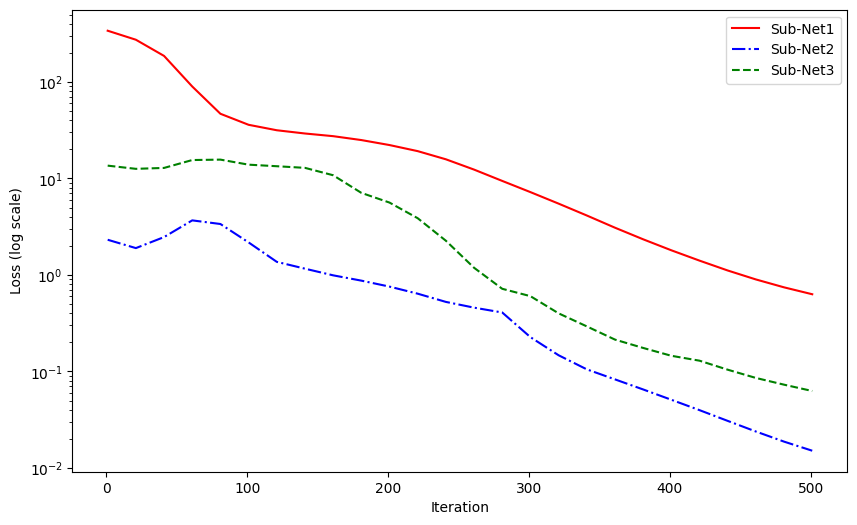

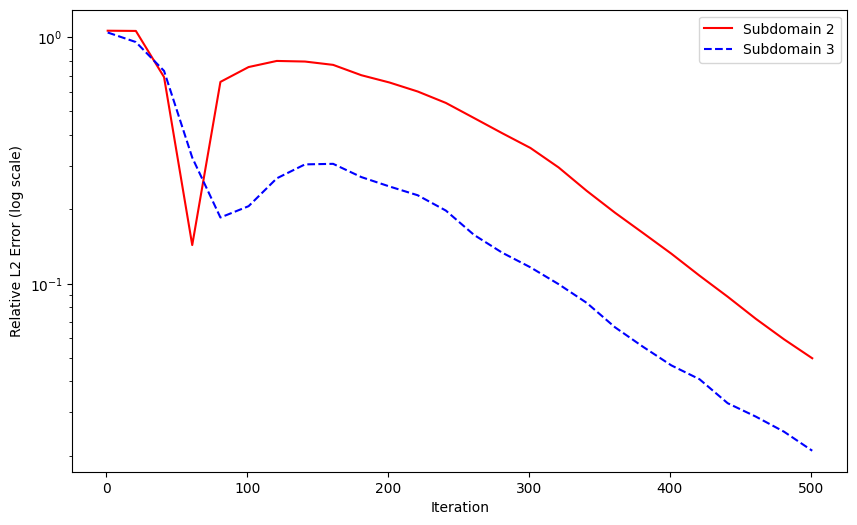

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:326: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


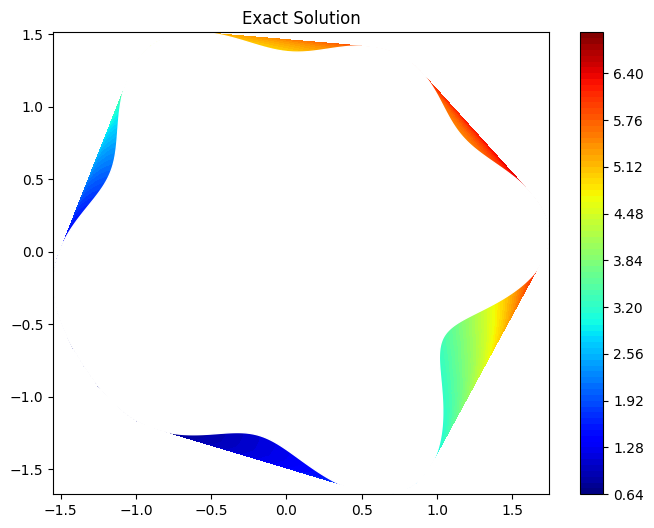

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:334: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


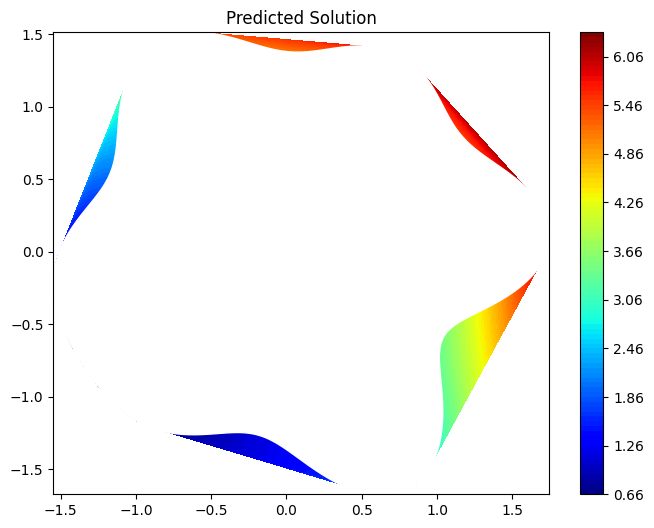

C:\Users\jolu2\AppData\Local\Temp\ipykernel_18332\1476462493.py:342: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))


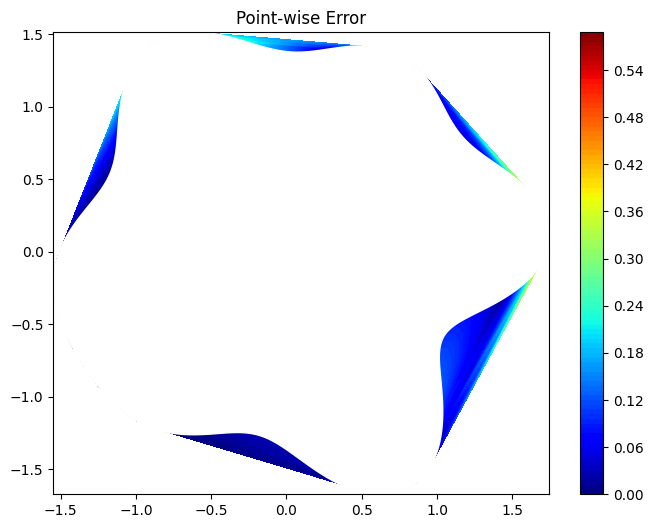

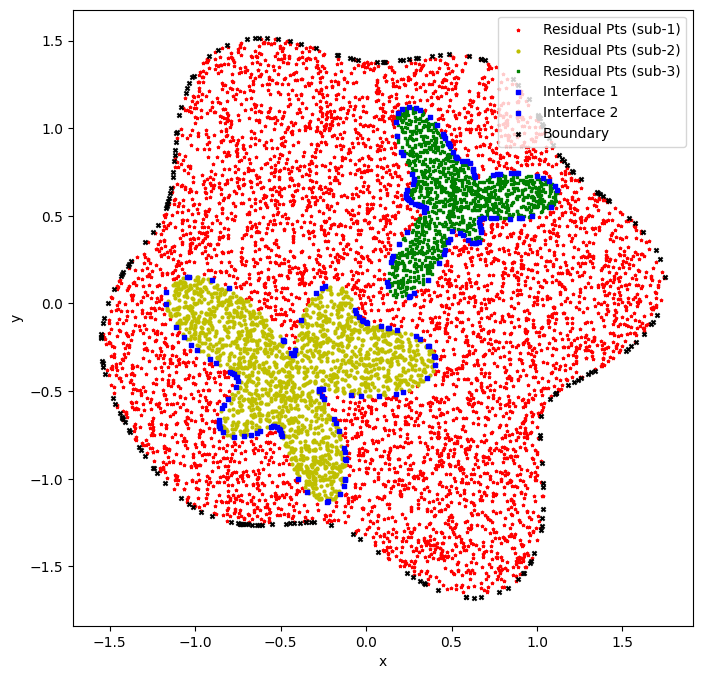

In [ ]:
import sys
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class MLP_Module(nn.Module):
    def __init__(self, layers, act='tanh'):
        super(MLP_Module, self).__init__()
        self.layers = layers
        self.linears = nn.ModuleList()
        self.A = nn.ParameterList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            # scale parameter for adaptive activation
            a = nn.Parameter(torch.tensor(0.05, dtype=torch.float64))
            self.A.append(a)
        self.act = act

    def forward(self, x):
        H = x
        for i, lin in enumerate(self.linears[:-1]):
            W_out = lin(H)
            scaled = 20.0 * self.A[i] * W_out
            if self.act == 'tanh':
                H = torch.tanh(scaled)
            elif self.act == 'sin':
                H = torch.sin(scaled)
            elif self.act == 'cos':
                H = torch.cos(scaled)
        # last layer
        Y = self.linears[-1](H)
        return Y

class XPINN:
    def __init__(self, X_ub, ub, X_f1, X_f2, X_f3, X_fi1, X_fi2,
                 layers1, layers2, layers3):
        # training data
        self.x_ub = torch.tensor(X_ub[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_ub = torch.tensor(X_ub[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.ub   = torch.tensor(ub, dtype=torch.float64, device=device)
        self.x_f1 = torch.tensor(X_f1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f1 = torch.tensor(X_f1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f2 = torch.tensor(X_f2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f2 = torch.tensor(X_f2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_f3 = torch.tensor(X_f3[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_f3 = torch.tensor(X_f3[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi1 = torch.tensor(X_fi1[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi1 = torch.tensor(X_fi1[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        self.x_fi2 = torch.tensor(X_fi2[:,0:1], dtype=torch.float64, device=device, requires_grad=True)
        self.y_fi2 = torch.tensor(X_fi2[:,1:2], dtype=torch.float64, device=device, requires_grad=True)
        # nets
        self.net1 = MLP_Module(layers1, act='tanh').to(device)
        self.net2 = MLP_Module(layers2, act='sin').to(device)
        self.net3 = MLP_Module(layers3, act='cos').to(device)
        # optimizers
        self.opt1 = optim.Adam(self.net1.parameters(), lr=8e-4)
        self.opt2 = optim.Adam(self.net2.parameters(), lr=8e-4)
        self.opt3 = optim.Adam(self.net3.parameters(), lr=8e-4)

    def net_u1(self, x, y):
        return self.net1(torch.cat([x, y], dim=1))

    def net_u2(self, x, y):
        return self.net2(torch.cat([x, y], dim=1))

    def net_u3(self, x, y):
        return self.net3(torch.cat([x, y], dim=1))

    def net_f(self):
        # auto-diff for PDE residuals and interface conditions
        u1 = self.net_u1(self.x_f1, self.y_f1)
        grads1 = torch.autograd.grad(u1, [self.x_f1, self.y_f1],
                                     grad_outputs=torch.ones_like(u1), create_graph=True)
        u1_x, u1_y = grads1
        u1_xx = torch.autograd.grad(u1_x, self.x_f1, grad_outputs=torch.ones_like(u1_x), create_graph=True)[0]
        u1_yy = torch.autograd.grad(u1_y, self.y_f1, grad_outputs=torch.ones_like(u1_y), create_graph=True)[0]
        f1 = u1_xx + u1_yy - (torch.exp(self.x_f1) + torch.exp(self.y_f1))

        u2 = self.net_u2(self.x_f2, self.y_f2)
        grads2 = torch.autograd.grad(u2, [self.x_f2, self.y_f2],
                                     grad_outputs=torch.ones_like(u2), create_graph=True)
        u2_x, u2_y = grads2
        u2_xx = torch.autograd.grad(u2_x, self.x_f2, grad_outputs=torch.ones_like(u2_x), create_graph=True)[0]
        u2_yy = torch.autograd.grad(u2_y, self.y_f2, grad_outputs=torch.ones_like(u2_y), create_graph=True)[0]
        f2 = u2_xx + u2_yy - (torch.exp(self.x_f2) + torch.exp(self.y_f2))

        u3 = self.net_u3(self.x_f3, self.y_f3)
        grads3 = torch.autograd.grad(u3, [self.x_f3, self.y_f3],
                                     grad_outputs=torch.ones_like(u3), create_graph=True)
        u3_x, u3_y = grads3
        u3_xx = torch.autograd.grad(u3_x, self.x_f3, grad_outputs=torch.ones_like(u3_x), create_graph=True)[0]
        u3_yy = torch.autograd.grad(u3_y, self.y_f3, grad_outputs=torch.ones_like(u3_y), create_graph=True)[0]
        f3 = u3_xx + u3_yy - (torch.exp(self.x_f3) + torch.exp(self.y_f3))

        # interface 1
        u1i1 = self.net_u1(self.x_fi1, self.y_fi1)
        u2i1 = self.net_u2(self.x_fi1, self.y_fi1)
        grads1i1 = torch.autograd.grad(u1i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u1i1), create_graph=True)
        u1i1_x, u1i1_y = grads1i1
        u1i1_xx = torch.autograd.grad(u1i1_x, self.x_fi1, grad_outputs=torch.ones_like(u1i1_x), create_graph=True)[0]
        u1i1_yy = torch.autograd.grad(u1i1_y, self.y_fi1, grad_outputs=torch.ones_like(u1i1_y), create_graph=True)[0]
        grads2i1 = torch.autograd.grad(u2i1, [self.x_fi1, self.y_fi1], grad_outputs=torch.ones_like(u2i1), create_graph=True)
        u2i1_x, u2i1_y = grads2i1
        u2i1_xx = torch.autograd.grad(u2i1_x, self.x_fi1, grad_outputs=torch.ones_like(u2i1_x), create_graph=True)[0]
        u2i1_yy = torch.autograd.grad(u2i1_y, self.y_fi1, grad_outputs=torch.ones_like(u2i1_y), create_graph=True)[0]
        fi1 = (u1i1_xx + u1i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1))) \
              - (u2i1_xx + u2i1_yy - (torch.exp(self.x_fi1) + torch.exp(self.y_fi1)))

        # interface 2
        u1i2 = self.net_u1(self.x_fi2, self.y_fi2)
        u3i2 = self.net_u3(self.x_fi2, self.y_fi2)
        grads1i2 = torch.autograd.grad(u1i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u1i2), create_graph=True)
        u1i2_x, u1i2_y = grads1i2
        u1i2_xx = torch.autograd.grad(u1i2_x, self.x_fi2, grad_outputs=torch.ones_like(u1i2_x), create_graph=True)[0]
        u1i2_yy = torch.autograd.grad(u1i2_y, self.y_fi2, grad_outputs=torch.ones_like(u1i2_y), create_graph=True)[0]
        grads3i2 = torch.autograd.grad(u3i2, [self.x_fi2, self.y_fi2], grad_outputs=torch.ones_like(u3i2), create_graph=True)
        u3i2_x, u3i2_y = grads3i2
        u3i2_xx = torch.autograd.grad(u3i2_x, self.x_fi2, grad_outputs=torch.ones_like(u3i2_x), create_graph=True)[0]
        u3i2_yy = torch.autograd.grad(u3i2_y, self.y_fi2, grad_outputs=torch.ones_like(u3i2_y), create_graph=True)[0]
        fi2 = (u1i2_xx + u1i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2))) \
              - (u3i2_xx + u3i2_yy - (torch.exp(self.x_fi2) + torch.exp(self.y_fi2)))

        uavgi1 = 0.5*(u1i1 + u2i1)
        uavgi2 = 0.5*(u1i2 + u3i2)

        return f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2

    def loss(self, f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2):
        ub1_pred = self.net_u1(self.x_ub, self.y_ub)
        loss1 = 20*nn.MSELoss()(ub1_pred, self.ub) \
                + torch.mean(f1**2) + torch.mean(fi1**2) + torch.mean(fi2**2) \
                + 20*torch.mean((u1i1 - uavgi1)**2) + 20*torch.mean((u1i2 - uavgi2)**2)
        loss2 = torch.mean(f2**2) + torch.mean(fi1**2) + 20*torch.mean((u2i1 - uavgi1)**2)
        loss3 = torch.mean(f3**2) + torch.mean(fi2**2) + 20*torch.mean((u3i2 - uavgi2)**2)
        return loss1, loss2, loss3

    def train(self, nIter, X_star1, X_star2, X_star3, u_exact2, u_exact3):
        MSE_history1, MSE_history2, MSE_history3 = [], [], []
        l2_err2, l2_err3 = [], []
        u_exact2_t = torch.tensor(u_exact2, dtype=torch.float64, device=device)
        u_exact3_t = torch.tensor(u_exact3, dtype=torch.float64, device=device)
        for it in range(nIter):
            # compute residuals
            f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2 = self.net_f()
            # compute losses
            l1, l2, l3 = self.loss(f1, f2, f3, fi1, fi2, uavgi1, uavgi2, u1i1, u1i2, u2i1, u3i2)

            # zero gradients
            self.opt1.zero_grad()
            self.opt2.zero_grad()
            self.opt3.zero_grad()
            # backward passes
            l1.backward(retain_graph=True)
            l2.backward(retain_graph=True)
            l3.backward()
            # optimizers step
            self.opt1.step()
            self.opt2.step()
            self.opt3.step()

            if it % 20 == 0:
                # full-domain predictions
                u1_full, u2_full, u3_full = self.predict(X_star1, X_star2, X_star3)
                # compute relative L2 errors on subdomains 2 & 3
                err2 = np.linalg.norm(u_exact2 - u2_full, 2)/np.linalg.norm(u_exact2, 2)
                err3 = np.linalg.norm(u_exact3 - u3_full, 2)/np.linalg.norm(u_exact3, 2)
                print(
                    f"It: {it}, Loss1: {l1.item():.3e}, Loss2: {l2.item():.3e}, Loss3: {l3.item():.3e}, " +
                    f"L2_err2: {err2:.3e}, L2_err3: {err3:.3e}"
                )
                MSE_history1.append(l1.item())
                MSE_history2.append(l2.item())
                MSE_history3.append(l3.item())
                l2_err2.append(err2)
                l2_err3.append(err3)
        return MSE_history1, MSE_history2, MSE_history3, l2_err2, l2_err3

    def predict(self, X_star1, X_star2, X_star3):
        x1 = torch.tensor(X_star1[:,0:1], dtype=torch.float64, device=device)
        y1 = torch.tensor(X_star1[:,1:2], dtype=torch.float64, device=device)
        x2 = torch.tensor(X_star2[:,0:1], dtype=torch.float64, device=device)
        y2 = torch.tensor(X_star2[:,1:2], dtype=torch.float64, device=device)
        x3 = torch.tensor(X_star3[:,0:1], dtype=torch.float64, device=device)
        y3 = torch.tensor(X_star3[:,1:2], dtype=torch.float64, device=device)
        u1 = self.net_u1(x1, y1).detach().cpu().numpy()
        u2 = self.net_u2(x2, y2).detach().cpu().numpy()
        u3 = self.net_u3(x3, y3).detach().cpu().numpy()
        return u1, u2, u3

# --------------------------------------------------------------------
if __name__ == '__main__':
    # Reproducibility
    set_seed(1234)
    # Use double precision for new layers
    torch.set_default_dtype(torch.float64)

    # Sampling parameters
    N_ub = 200
    N_f1 = 5000
    N_f2 = 1800
    N_f3 = 1200
    N_I1 = 100
    N_I2 = 100

    # Neural network architectures
    layers1 = [2, 30, 30, 1]
    layers2 = [2, 20, 20, 20, 20, 1]
    layers3 = [2, 25, 25, 25, 1]

    # Load data
    data = scipy.io.loadmat('./XPINN_2D_PoissonEqn.mat')
    x_f1 = data['x_f1'].flatten()[:, None]
    y_f1 = data['y_f1'].flatten()[:, None]
    x_f2 = data['x_f2'].flatten()[:, None]
    y_f2 = data['y_f2'].flatten()[:, None]
    x_f3 = data['x_f3'].flatten()[:, None]
    y_f3 = data['y_f3'].flatten()[:, None]
    xi1  = data['xi1'].flatten()[:, None]
    yi1  = data['yi1'].flatten()[:, None]
    xi2  = data['xi2'].flatten()[:, None]
    yi2  = data['yi2'].flatten()[:, None]
    xb   = data['xb'].flatten()[:, None]
    yb   = data['yb'].flatten()[:, None]

    ub_train  = data['ub'].flatten()[:, None]
    u_exact   = data['u_exact'].flatten()[:, None]
    u_exact2  = data['u_exact2'].flatten()[:, None]
    u_exact3  = data['u_exact3'].flatten()[:, None]

    # Full prediction points in each subdomain
    X_star1 = np.hstack((x_f1, y_f1))
    X_star2 = np.hstack((x_f2, y_f2))
    X_star3 = np.hstack((x_f3, y_f3))

    # Training inputs
    X_f1_train  = np.hstack((x_f1, y_f1))
    X_f2_train  = np.hstack((x_f2, y_f2))
    X_f3_train  = np.hstack((x_f3, y_f3))
    X_ub_train  = np.hstack((xb, yb))
    X_fi1_train = np.hstack((xi1, yi1))
    X_fi2_train = np.hstack((xi2, yi2))

    # Subsample points
    idx1 = np.random.choice(X_f1_train.shape[0], N_f1, replace=False)
    X_f1_train = X_f1_train[idx1, :]
    idx2 = np.random.choice(X_f2_train.shape[0], N_f2, replace=False)
    X_f2_train = X_f2_train[idx2, :]
    idx3 = np.random.choice(X_f3_train.shape[0], N_f3, replace=False)
    X_f3_train = X_f3_train[idx3, :]
    idx4 = np.random.choice(X_ub_train.shape[0], N_ub, replace=False)
    X_ub_train = X_ub_train[idx4, :]
    ub_train   = ub_train[idx4, :]
    idxi1 = np.random.choice(X_fi1_train.shape[0], N_I1, replace=False)
    X_fi1_train = X_fi1_train[idxi1, :]
    idxi2 = np.random.choice(X_fi2_train.shape[0], N_I2, replace=False)
    X_fi2_train = X_fi2_train[idxi2, :]

    # Instantiate and prepare model
    model = XPINN(X_ub_train, ub_train,
                  X_f1_train, X_f2_train, X_f3_train,
                  X_fi1_train, X_fi2_train,
                  layers1, layers2, layers3)
    # Ensure all sub-net parameters are float64
    model.net1.double()
    model.net2.double()
    model.net3.double()

    # Training
    Max_iter = 501
    start_time = time.time()
    MSE_hist1, MSE_hist2, MSE_hist3, l2_err2, l2_err3 = \
        model.train(Max_iter, X_star1, X_star2, X_star3, u_exact2, u_exact3)
    elapsed = time.time() - start_time
    print(f'Training time: {elapsed:.4f}')

    # Prediction
    u_pred1, u_pred2, u_pred3 = model.predict(X_star1, X_star2, X_star3)
    u_pred = np.vstack((u_pred1, u_pred2, u_pred3)).flatten()

    # Plot MSE history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), MSE_hist1, 'r-', label='Sub-Net1')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist2, 'b-.', label='Sub-Net2')
    plt.plot(range(1, Max_iter+1, 20), MSE_hist3, 'g--', label='Sub-Net3')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Plot L2 error history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_iter+1, 20), l2_err2, 'r-', label='Subdomain 2')
    plt.plot(range(1, Max_iter+1, 20), l2_err3, 'b--', label='Subdomain 3')
    plt.xlabel('Iteration')
    plt.ylabel('Relative L2 Error (log scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Concatenate coordinates for triangulation
    x_tot = np.concatenate((x_f1, x_f2, x_f3))
    y_tot = np.concatenate((y_f1, y_f2, y_f3))
    triang_total = tri.Triangulation(x_tot.flatten(), y_tot.flatten())

    # Plot exact solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_exact.flatten(), 100, cmap='jet')
    XX = np.vstack((np.hstack((xb, yb)), np.hstack((xi2, yi2)), np.array([[xb[-1,0], yb[-1,0]]])))
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Exact Solution')
    plt.show()

    # Plot predicted solution contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, u_pred, 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Predicted Solution')
    plt.show()

    # Plot point-wise error contour
    plt.figure(figsize=(8, 6))
    plt.tricontourf(triang_total, np.abs(u_exact.flatten() - u_pred), 100, cmap='jet')
    plt.gca().add_patch(Polygon(XX, closed=True, fill=True, color='w', edgecolor='w'))
    plt.colorbar()
    plt.title('Point-wise Error')
    plt.show()

    # Scatter data points
    plt.figure(figsize=(8, 8))
    plt.scatter(X_f1_train[:,0], X_f1_train[:,1], c='r', s=4, marker='*', label='Residual Pts (sub-1)')
    plt.scatter(X_f2_train[:,0], X_f2_train[:,1], c='y', s=4, marker='o', label='Residual Pts (sub-2)')
    plt.scatter(X_f3_train[:,0], X_f3_train[:,1], c='g', s=4, marker='s', label='Residual Pts (sub-3)')
    plt.scatter(X_fi1_train[:,0], X_fi1_train[:,1], c='b', s=7, marker='s', label='Interface 1')
    plt.scatter(X_fi2_train[:,0], X_fi2_train[:,1], c='b', s=7, marker='s', label='Interface 2')
    plt.scatter(X_ub_train[:,0], X_ub_train[:,1], c='k', s=9, marker='x', label='Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
